In [1]:
"""
Bayesian Neural Network
=======================

We demonstrate how to use NUTS to do inference on a simple (small)
Bayesian neural network with two hidden layers.
"""

import argparse
import os
import time

import matplotlib
import matplotlib.pyplot as plt
import numpy as onp

from jax import vmap
import jax.numpy as np
import jax.random as random
from jax.nn import elu, relu

import numpyro
from numpyro import handlers
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS

matplotlib.use('Agg')  # noqa: E402


In [2]:
numpyro.set_platform('cpu')
numpyro.set_host_device_count(1)

In [3]:


# the non-linearity we use in our neural network
def nonlin(x):
    #return np.tanh(x)
    return elu(x)


# a two-layer bayesian neural network with computational flow
# given by D_X => D_H => D_H => D_Y where D_H is the number of
# hidden units. (note we indicate tensor dimensions in the comments)
def model(X, Y, D_H):

    D_X, D_Y = X.shape[1], 1

    # sample first layer (we put unit normal priors on all weights)
    w1 = numpyro.sample("w1", dist.Normal(np.zeros((D_X, D_H)), np.ones((D_X, D_H))))  # D_X D_H
    z1 = nonlin(np.matmul(X, w1))   # N D_H  <= first layer of activations

    # sample second layer
    w2 = numpyro.sample("w2", dist.Normal(np.zeros((D_H, D_H)), np.ones((D_H, D_H))))  # D_H D_H
    z2 = nonlin(np.matmul(z1, w2))  # N D_H  <= second layer of activations

    # sample final layer of weights and neural network output
    w3 = numpyro.sample("w3", dist.Normal(np.zeros((D_H, D_Y)), np.ones((D_H, D_Y))))  # D_H D_Y
    z3 = np.matmul(z2, w3)  # N D_Y  <= output of the neural network

    # we put a prior on the observation noise
    prec_obs = numpyro.sample("prec_obs", dist.Gamma(3.0, 1.0))
    sigma_obs = 1.0 / np.sqrt(prec_obs)

    # observe data
    return numpyro.sample("Y", dist.Normal(z3, sigma_obs), obs=Y)




In [4]:
# create artificial regression dataset
def get_data(N=50, D_X=3, sigma_obs=0.05, N_test=500):
    D_Y = 1  # create 1d outputs
    onp.random.seed(0)
    X = np.linspace(-1, 1, N)
    X = np.power(X[:, onp.newaxis], np.arange(D_X))
    W = 0.5 * onp.random.randn(D_X)
    Y = np.dot(X, W) + 0.5 * np.power(0.5 + X[:, 1], 2.0) * np.sin(4.0 * X[:, 1])
    Y += sigma_obs * onp.random.randn(N)
    Y = Y[:, onp.newaxis]
    Y -= np.mean(Y)
    Y /= np.std(Y)

    assert X.shape == (N, D_X)
    assert Y.shape == (N, D_Y)

    X_test = np.linspace(-1.3, 1.3, N_test)
    X_test = np.power(X_test[:, onp.newaxis], np.arange(D_X))

    return X, Y, X_test

In [5]:


# helper function for HMC inference
def run_inference(model, args, rng_key, X, Y, D_H):
    start = time.time()
    kernel = NUTS(model)
    mcmc = MCMC(kernel, args['num_warmup'], args['num_samples'], num_chains=args['num_chains'],
                progress_bar=True)
    mcmc.run(rng_key, X, Y, D_H)
    mcmc.print_summary()
    print('\nMCMC elapsed time:', time.time() - start)
    return mcmc.get_samples()


# helper function for prediction
def predict(model, rng_key, samples, X, D_H):
    model = handlers.substitute(handlers.seed(model, rng_key), samples)
    # note that Y will be sampled in the model because we pass Y=None here
    model_trace = handlers.trace(model).get_trace(X=X, Y=None, D_H=D_H)
    return model_trace['Y']['value']




In [6]:
args = {'num_samples': 2000, 'num_chains': 1, 'num_warmup': 2000}
N, D_X, D_H = 20, 3, 25

def run_inference_and_compute_eigs(N, D_X=3, D_H=15):
    X, Y, X_test = get_data(N=N, D_X=D_X)

    # do inference
    rng_key, rng_key_predict = random.split(random.PRNGKey(0))
    samples = run_inference(model, args, rng_key, X, Y, D_H)
    
    # predict Y_test at inputs X_test
    vmap_args = (samples, random.split(rng_key_predict, args['num_samples'] * args['num_chains']))
#     test_predictions = vmap(lambda samples, rng_key: predict(model, rng_key, samples, X_test, D_H))(*vmap_args)
#     test_predictions = test_predictions[..., 0]

    train_predictions = vmap(lambda samples, rng_key: predict(model, rng_key, samples, X, D_H))(*vmap_args)
    train_predictions = train_predictions[..., 0]

    # compute mean prediction and confidence interval around median
    #mean_prediction = np.mean(test_predictions, axis=0)
    #percentiles = onp.percentile(test_predictions, [5.0, 95.0], axis=0)
    
    pars_list = []
    for keys in samples.keys():
        items = samples[keys]
        pars_list.append(items.reshape(args['num_samples'],-1))
    pars = np.hstack(pars_list)
    
    pars_eigs = np.linalg.svd(pars)[1]**2 / (args['num_samples']-1)
    
    function_eigs = np.linalg.svd(np.cov(train_predictions.T))[1]**2 / (args['num_samples'] - 1)
    
    return pars_eigs, function_eigs

In [8]:
n_list = [20, 100, 200, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 
          1400, 1500, 1600, 1800, 2000, 2500, 3000]

In [9]:
len(n_list)

19

In [10]:
all_eig_list = []
for i in range(5):
    print('Trial: ', i)
    inf_list = []
    for n in n_list:
        print('DAta points: ', n)
        inf_list.append(
            run_inference_and_compute_eigs(n, D_H=20)
        )
    all_eig_list.append(inf_list)
#all_eig_list = [run_inference_and_compute_eigs(n, D_H=20) for n in n_list]

Trial:  0
DAta points:  20


sample: 100%|██████████| 4000/4000 [01:41<00:00, 39.34it/s, 1023 steps of size 5.33e-03. acc. prob=0.88]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  prec_obs      7.69      2.44      7.41      3.86     11.53   2443.71      1.00
   w1[0,0]     -0.04      0.96     -0.05     -1.57      1.63   2589.96      1.00
   w1[0,1]     -0.03      0.98     -0.00     -1.67      1.47   2367.28      1.00
   w1[0,2]     -0.01      0.96     -0.01     -1.60      1.53   2673.87      1.00
   w1[0,3]     -0.05      0.97     -0.05     -1.56      1.56   2539.79      1.00
   w1[0,4]     -0.02      1.01      0.03     -1.56      1.66   2917.97      1.00
   w1[0,5]     -0.05      1.00     -0.05     -1.54      1.77   2720.76      1.00
   w1[0,6]     -0.01      0.99     -0.03     -1.71      1.53   2575.77      1.00
   w1[0,7]     -0.04      0.94     -0.04     -1.60      1.47   2002.65      1.00
   w1[0,8]     -0.05      0.96     -0.05     -1.56      1.56   2095.62      1.00
   w1[0,9]     -0.05      0.98     -0.03     -1.65      1.55   3228.75      1.00
  w1[0,10]     -0.05      1

DAta points:  100


sample: 100%|██████████| 4000/4000 [02:31<00:00, 26.37it/s, 1023 steps of size 1.44e-03. acc. prob=0.92]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  prec_obs     18.70      2.66     18.47     14.64     23.19    416.72      1.00
   w1[0,0]     -0.09      0.91     -0.10     -1.46      1.50    310.52      1.00
   w1[0,1]     -0.05      1.05     -0.03     -1.80      1.60    201.74      1.00
   w1[0,2]     -0.02      0.95      0.02     -1.60      1.43    241.09      1.00
   w1[0,3]     -0.19      1.00     -0.19     -1.79      1.46    152.18      1.00
   w1[0,4]     -0.08      0.97     -0.09     -1.53      1.59    239.09      1.00
   w1[0,5]     -0.17      0.96     -0.18     -1.70      1.44    224.47      1.01
   w1[0,6]     -0.15      1.03     -0.15     -1.93      1.48    145.21      1.00
   w1[0,7]     -0.02      0.97      0.00     -1.61      1.51    227.86      1.01
   w1[0,8]     -0.06      0.97     -0.08     -1.56      1.62    271.61      1.00
   w1[0,9]     -0.16      0.97     -0.17     -1.76      1.44    227.88      1.00
  w1[0,10]     -0.12      0

DAta points:  200


sample: 100%|██████████| 4000/4000 [03:39<00:00, 18.26it/s, 1023 steps of size 9.45e-04. acc. prob=0.93]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  prec_obs     21.91      2.20     21.79     18.50     25.62    163.75      1.00
   w1[0,0]     -0.14      0.95     -0.17     -1.66      1.43    115.82      1.02
   w1[0,1]      0.08      1.15      0.03     -1.80      2.00     70.24      1.01
   w1[0,2]     -0.08      0.94     -0.03     -1.57      1.49    146.10      1.00
   w1[0,3]     -0.22      0.98     -0.27     -1.81      1.37     75.71      1.00
   w1[0,4]     -0.06      0.96     -0.06     -1.54      1.53     82.01      1.03
   w1[0,5]     -0.21      1.03     -0.14     -1.99      1.39    107.09      1.00
   w1[0,6]     -0.12      0.97     -0.13     -1.78      1.41    106.46      1.00
   w1[0,7]     -0.07      0.98     -0.12     -1.57      1.48    116.67      1.03
   w1[0,8]     -0.00      0.99      0.00     -1.69      1.50     88.47      1.00
   w1[0,9]     -0.18      0.96     -0.18     -1.86      1.34    114.33      1.00
  w1[0,10]     -0.11      1

DAta points:  500


sample: 100%|██████████| 4000/4000 [06:37<00:00, 10.05it/s, 1023 steps of size 4.77e-04. acc. prob=0.95]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  prec_obs     24.62      1.42     24.58     22.24     26.80     35.34      1.00
   w1[0,0]      0.04      0.88      0.07     -1.51      1.52     46.69      1.08
   w1[0,1]     -0.13      1.10     -0.16     -2.02      1.50     31.06      1.02
   w1[0,2]      0.02      0.88      0.07     -1.42      1.45     30.98      1.00
   w1[0,3]     -0.54      0.96     -0.53     -1.99      1.05     33.79      1.01
   w1[0,4]      0.14      1.04      0.17     -1.49      1.99     11.63      1.30
   w1[0,5]     -0.30      0.88     -0.18     -1.80      1.01     49.66      1.00
   w1[0,6]     -0.10      1.05     -0.01     -1.82      1.49     25.79      1.01
   w1[0,7]     -0.22      0.90     -0.27     -1.67      1.16     18.96      1.11
   w1[0,8]      0.22      1.06      0.37     -1.53      1.71     23.23      1.00
   w1[0,9]     -0.25      0.81     -0.28     -1.53      1.12     43.59      1.04
  w1[0,10]     -0.18      0

DAta points:  600


sample: 100%|██████████| 4000/4000 [07:39<00:00,  8.71it/s, 1023 steps of size 5.11e-04. acc. prob=0.93]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  prec_obs     25.10      1.31     25.06     23.02     27.21     41.69      1.01
   w1[0,0]     -0.35      0.86     -0.37     -1.77      1.04     48.82      1.00
   w1[0,1]     -0.17      1.11     -0.21     -1.86      1.72     36.07      1.00
   w1[0,2]     -0.04      0.85     -0.04     -1.49      1.39     38.64      1.00
   w1[0,3]     -0.61      0.97     -0.63     -2.19      0.90     30.81      1.00
   w1[0,4]     -0.27      0.96     -0.30     -1.77      1.42     21.40      1.10
   w1[0,5]     -0.34      1.06     -0.22     -2.10      1.37     37.92      1.01
   w1[0,6]     -0.10      0.96     -0.08     -1.57      1.57     31.46      1.01
   w1[0,7]     -0.08      0.90     -0.11     -1.54      1.35     49.64      1.03
   w1[0,8]      0.01      1.01      0.12     -1.75      1.52     34.76      1.02
   w1[0,9]     -0.32      0.92     -0.35     -1.74      1.25     51.31      1.07
  w1[0,10]     -0.27      0

DAta points:  700


sample: 100%|██████████| 4000/4000 [08:40<00:00,  7.69it/s, 1023 steps of size 4.13e-04. acc. prob=0.94]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  prec_obs     24.79      1.17     24.76     22.81     26.68     20.93      1.00
   w1[0,0]     -0.15      0.85     -0.13     -1.51      1.22     37.51      1.10
   w1[0,1]     -0.07      1.10     -0.06     -1.90      1.56     24.73      1.00
   w1[0,2]     -0.19      0.84     -0.14     -1.57      1.09     21.30      1.07
   w1[0,3]     -0.38      1.01     -0.32     -1.99      1.27     28.92      1.01
   w1[0,4]     -0.12      1.04     -0.04     -1.92      1.57     11.48      1.26
   w1[0,5]     -0.06      0.98     -0.07     -1.54      1.91     23.36      1.00
   w1[0,6]     -0.42      0.97     -0.33     -2.18      0.93     12.35      1.01
   w1[0,7]     -0.18      1.04     -0.27     -1.92      1.34     12.51      1.23
   w1[0,8]      0.04      1.11      0.10     -1.76      1.76     16.04      1.00
   w1[0,9]     -0.07      0.93     -0.08     -1.55      1.40     15.89      1.10
  w1[0,10]     -0.31      0

DAta points:  800


sample: 100%|██████████| 4000/4000 [09:44<00:00,  6.85it/s, 1023 steps of size 3.48e-04. acc. prob=0.96]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  prec_obs     25.28      1.09     25.27     23.45     27.12     21.60      1.00
   w1[0,0]     -0.38      0.79     -0.47     -1.54      1.02     32.73      1.00
   w1[0,1]      0.05      1.02      0.02     -1.60      1.85     23.39      1.00
   w1[0,2]     -0.21      0.91     -0.17     -1.73      1.25     16.77      1.01
   w1[0,3]     -0.53      0.90     -0.54     -2.27      0.70     22.59      1.00
   w1[0,4]      0.08      1.06      0.02     -1.78      1.68      8.92      1.41
   w1[0,5]     -0.43      0.96     -0.43     -1.81      1.26     18.05      1.07
   w1[0,6]     -0.36      0.99     -0.27     -2.00      1.15     13.64      1.00
   w1[0,7]     -0.23      1.01     -0.28     -1.76      1.28      8.18      1.29
   w1[0,8]      0.15      1.05      0.30     -1.75      1.64     13.29      1.01
   w1[0,9]     -0.32      0.95     -0.44     -1.78      1.49     14.61      1.04
  w1[0,10]     -0.42      0

DAta points:  900


sample: 100%|██████████| 4000/4000 [10:28<00:00,  6.36it/s, 1023 steps of size 3.79e-04. acc. prob=0.94]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  prec_obs     25.99      1.05     26.02     23.80     27.32     14.39      1.00
   w1[0,0]     -0.33      0.88     -0.33     -1.85      1.14     28.11      1.08
   w1[0,1]      0.10      1.13      0.13     -1.98      1.51     20.02      1.07
   w1[0,2]     -0.22      0.85     -0.17     -1.51      1.18     25.32      1.01
   w1[0,3]     -0.58      1.15     -0.64     -2.37      1.21     22.98      1.00
   w1[0,4]     -0.01      1.06      0.06     -1.95      1.51     10.14      1.35
   w1[0,5]     -0.37      1.01     -0.40     -2.02      1.31     13.86      1.23
   w1[0,6]     -0.27      0.94     -0.15     -1.90      1.15     19.77      1.00
   w1[0,7]     -0.11      1.03      0.18     -1.88      1.27      7.54      1.32
   w1[0,8]      0.05      1.05      0.18     -1.74      1.59     24.57      1.00
   w1[0,9]     -0.37      0.84     -0.23     -1.78      0.78     25.58      1.00
  w1[0,10]     -0.56      0

DAta points:  1000


sample: 100%|██████████| 4000/4000 [11:39<00:00,  5.72it/s, 1023 steps of size 4.56e-04. acc. prob=0.88]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  prec_obs     26.32      1.04     26.32     24.51     27.95     30.68      1.00
   w1[0,0]     -0.24      0.91     -0.22     -1.74      1.20      9.26      1.30
   w1[0,1]      0.21      1.17      0.04     -1.54      2.16     22.05      1.05
   w1[0,2]     -0.32      0.81     -0.31     -1.66      1.06     14.92      1.00
   w1[0,3]     -0.48      1.08     -0.54     -2.19      1.18     28.03      1.01
   w1[0,4]     -0.02      0.97      0.12     -1.88      1.43     19.36      1.04
   w1[0,5]     -0.34      0.95     -0.29     -1.76      1.30     34.67      1.11
   w1[0,6]     -0.32      0.85     -0.35     -1.77      1.00     40.52      1.02
   w1[0,7]     -0.07      1.00     -0.04     -1.53      1.54     11.69      1.10
   w1[0,8]      0.01      0.94      0.07     -1.52      1.41     24.56      1.17
   w1[0,9]     -0.23      0.97     -0.18     -1.70      1.55     19.80      1.02
  w1[0,10]     -0.18      0

DAta points:  1100


sample: 100%|██████████| 4000/4000 [12:26<00:00,  5.36it/s, 1023 steps of size 2.76e-04. acc. prob=0.96]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  prec_obs     27.13      1.02     27.13     25.21     28.66      8.22      1.07
   w1[0,0]     -0.58      0.79     -0.74     -1.86      0.67     16.43      1.10
   w1[0,1]      0.04      1.08      0.12     -1.72      1.52     17.60      1.16
   w1[0,2]     -0.29      0.89     -0.29     -1.71      1.15      6.25      1.16
   w1[0,3]     -0.62      0.97     -0.58     -2.08      1.12     19.60      1.00
   w1[0,4]      0.47      1.20      0.59     -1.81      2.21      4.74      1.31
   w1[0,5]     -0.49      0.80     -0.45     -1.94      0.64     21.79      1.01
   w1[0,6]     -0.33      0.93     -0.24     -1.80      1.28     11.16      1.03
   w1[0,7]     -0.19      0.98      0.08     -1.84      1.15      4.01      1.81
   w1[0,8]      0.25      0.92      0.31     -1.32      1.74      9.24      1.24
   w1[0,9]     -0.34      0.90     -0.21     -1.65      1.13     10.23      1.24
  w1[0,10]     -0.41      0

DAta points:  1200


sample: 100%|██████████| 4000/4000 [13:45<00:00,  4.85it/s, 1023 steps of size 3.55e-04. acc. prob=0.93]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  prec_obs     27.33      0.92     27.32     25.77     28.78     25.19      1.00
   w1[0,0]     -0.22      0.72     -0.25     -1.28      1.01     17.42      1.18
   w1[0,1]     -0.11      1.06     -0.10     -1.83      1.55     20.35      1.08
   w1[0,2]     -0.42      0.86     -0.53     -1.74      0.87      6.96      1.17
   w1[0,3]     -0.71      0.93     -0.68     -2.25      0.63     23.47      1.02
   w1[0,4]     -0.19      0.88     -0.14     -1.54      1.32     17.11      1.06
   w1[0,5]     -0.24      0.88     -0.25     -1.85      0.98     24.34      1.02
   w1[0,6]     -0.23      0.96     -0.28     -1.88      1.23     23.81      1.02
   w1[0,7]      0.08      0.82     -0.02     -1.30      1.19     17.10      1.14
   w1[0,8]      0.51      0.92      0.67     -1.10      1.98     21.63      1.06
   w1[0,9]     -0.47      0.85     -0.54     -1.71      1.02     22.84      1.00
  w1[0,10]     -0.37      0

DAta points:  1300


sample: 100%|██████████| 4000/4000 [13:53<00:00,  4.80it/s, 1023 steps of size 4.84e-04. acc. prob=0.82]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  prec_obs     27.45      0.93     27.49     25.97     28.94     40.47      1.00
   w1[0,0]     -0.26      0.84     -0.30     -1.76      1.00     48.73      1.03
   w1[0,1]     -0.09      1.06     -0.14     -1.85      1.46     28.21      1.06
   w1[0,2]     -0.15      0.85     -0.14     -1.46      1.37     30.14      1.00
   w1[0,3]     -0.36      0.96     -0.43     -1.77      1.34     25.26      1.02
   w1[0,4]     -0.04      0.97      0.04     -1.51      1.57     17.60      1.04
   w1[0,5]     -0.37      0.90     -0.38     -2.04      0.99     32.98      1.00
   w1[0,6]     -0.23      1.11     -0.15     -2.04      1.60     11.14      1.00
   w1[0,7]     -0.17      1.06     -0.20     -1.94      1.40     16.70      1.20
   w1[0,8]      0.12      1.02      0.16     -1.60      1.68     24.85      1.02
   w1[0,9]     -0.17      0.90     -0.19     -1.57      1.27     23.37      1.06
  w1[0,10]     -0.43      0

DAta points:  1400


sample: 100%|██████████| 4000/4000 [15:21<00:00,  4.34it/s, 1023 steps of size 3.74e-04. acc. prob=0.90]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  prec_obs     27.72      0.90     27.64     26.09     29.07     17.74      1.01
   w1[0,0]     -0.42      0.73     -0.47     -1.55      0.78     20.52      1.39
   w1[0,1]      0.04      1.07      0.09     -1.77      1.56     14.63      1.03
   w1[0,2]     -0.59      0.69     -0.59     -1.77      0.55     23.08      1.00
   w1[0,3]     -1.06      0.86     -1.14     -2.45      0.18     20.68      1.02
   w1[0,4]     -0.11      1.02      0.05     -1.62      1.65     11.37      1.09
   w1[0,5]     -0.48      0.88     -0.51     -1.77      1.14     17.52      1.02
   w1[0,6]     -0.24      1.02     -0.24     -1.88      1.47     20.59      1.01
   w1[0,7]      0.05      0.92      0.15     -1.38      1.52     23.07      1.10
   w1[0,8]      0.37      1.09      0.57     -1.55      1.92     21.87      1.00
   w1[0,9]     -0.31      0.83     -0.33     -1.47      1.16     27.10      1.07
  w1[0,10]     -1.01      0

DAta points:  1500


sample: 100%|██████████| 4000/4000 [17:21<00:00,  3.84it/s, 1023 steps of size 3.00e-04. acc. prob=0.94]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  prec_obs     27.54      0.87     27.56     26.01     28.82     18.64      1.01
   w1[0,0]     -0.07      0.74     -0.02     -1.26      1.18     15.09      1.36
   w1[0,1]      0.04      1.05      0.03     -1.51      1.96      8.82      1.42
   w1[0,2]     -0.40      0.83     -0.48     -1.79      1.08      7.94      1.15
   w1[0,3]     -1.11      0.85     -1.13     -2.39     -0.03     23.32      1.03
   w1[0,4]     -0.12      1.03     -0.00     -2.04      1.29      9.57      1.18
   w1[0,5]     -0.22      0.80     -0.11     -1.47      1.14     21.28      1.00
   w1[0,6]      0.03      1.18      0.06     -2.03      1.76     11.48      1.00
   w1[0,7]     -0.40      0.91     -0.40     -1.69      1.03      5.11      1.63
   w1[0,8]      0.13      1.06      0.28     -1.82      1.62     13.96      1.08
   w1[0,9]     -0.62      0.70     -0.63     -1.69      0.62     19.76      1.05
  w1[0,10]     -0.63      0

DAta points:  1600


sample: 100%|██████████| 4000/4000 [18:21<00:00,  3.63it/s, 1023 steps of size 4.09e-04. acc. prob=0.84]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  prec_obs     27.45      0.89     27.47     25.81     28.77     27.43      1.01
   w1[0,0]     -0.07      0.81     -0.05     -1.38      1.24     17.01      1.24
   w1[0,1]      0.32      1.04      0.34     -1.32      2.09     20.78      1.06
   w1[0,2]     -0.34      0.82     -0.39     -1.63      0.94     10.84      1.01
   w1[0,3]     -0.73      1.12     -0.89     -2.48      1.20     19.68      1.00
   w1[0,4]     -0.25      0.93     -0.13     -1.63      1.17     13.97      1.05
   w1[0,5]     -0.47      0.81     -0.37     -1.86      0.71     27.76      1.02
   w1[0,6]     -0.36      0.82     -0.39     -1.69      1.01     28.74      1.01
   w1[0,7]      0.02      1.07      0.18     -1.71      1.70      4.36      1.94
   w1[0,8]      0.38      1.02      0.39     -1.44      2.00     18.63      1.00
   w1[0,9]     -0.15      0.89     -0.13     -1.46      1.44     13.28      1.16
  w1[0,10]     -0.30      1

DAta points:  1800


sample: 100%|██████████| 4000/4000 [18:30<00:00,  3.60it/s, 1023 steps of size 4.61e-04. acc. prob=0.79]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  prec_obs     27.19      0.85     27.16     25.71     28.51     20.14      1.00
   w1[0,0]     -0.17      0.94     -0.19     -1.72      1.41     28.48      1.13
   w1[0,1]     -0.05      0.97     -0.01     -1.74      1.43     20.18      1.09
   w1[0,2]     -0.18      0.82     -0.24     -1.48      1.06     28.59      1.01
   w1[0,3]     -0.55      0.93     -0.50     -2.21      0.75     35.09      1.03
   w1[0,4]      0.04      1.03     -0.07     -1.38      2.09     11.21      1.40
   w1[0,5]     -0.40      0.88     -0.35     -1.83      0.89     32.01      1.03
   w1[0,6]     -0.21      1.03     -0.17     -1.98      1.36     13.33      1.05
   w1[0,7]      0.16      0.90      0.16     -1.22      1.72     29.60      1.07
   w1[0,8]      0.08      0.90      0.16     -1.52      1.43     26.09      1.10
   w1[0,9]     -0.01      0.89     -0.06     -1.39      1.42     12.70      1.03
  w1[0,10]     -0.52      0

DAta points:  2000


sample: 100%|██████████| 4000/4000 [20:29<00:00,  3.25it/s, 1023 steps of size 2.11e-04. acc. prob=0.97]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  prec_obs     27.32      0.73     27.38     26.14     28.45      5.18      1.26
   w1[0,0]     -0.26      0.52     -0.27     -1.06      0.64      9.30      1.33
   w1[0,1]      0.20      0.86      0.14     -1.21      1.61     10.68      1.19
   w1[0,2]     -0.43      0.76     -0.45     -1.69      0.85      9.12      1.07
   w1[0,3]     -1.33      0.91     -1.36     -2.74     -0.03      8.53      1.21
   w1[0,4]      0.18      1.08      0.50     -1.78      1.73      4.98      1.35
   w1[0,5]     -0.67      0.84     -0.51     -2.06      0.60     13.83      1.14
   w1[0,6]     -0.46      0.92     -0.30     -2.02      0.98      8.80      1.01
   w1[0,7]     -0.52      0.85     -0.29     -2.09      0.82      6.25      1.30
   w1[0,8]      0.37      0.91      0.57     -1.13      1.82      6.87      1.39
   w1[0,9]     -0.31      0.84     -0.38     -1.45      1.19      8.16      1.32
  w1[0,10]     -0.92      0

DAta points:  2500


sample: 100%|██████████| 4000/4000 [25:10<00:00,  2.65it/s, 1023 steps of size 3.08e-04. acc. prob=0.91]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  prec_obs     27.24      0.65     27.22     26.24     28.45     14.02      1.00
   w1[0,0]     -0.07      0.71     -0.07     -1.41      0.93     20.83      1.09
   w1[0,1]      0.05      0.79      0.06     -1.14      1.42      7.69      1.53
   w1[0,2]     -0.48      0.83     -0.55     -1.79      1.03      8.48      1.25
   w1[0,3]     -1.53      0.84     -1.54     -2.78     -0.12      9.69      1.01
   w1[0,4]     -0.31      1.03     -0.31     -1.96      1.34      6.47      1.47
   w1[0,5]      0.05      0.91      0.14     -1.61      1.37     27.91      1.01
   w1[0,6]     -0.46      1.01     -0.47     -2.05      1.22     13.31      1.01
   w1[0,7]     -0.19      0.95      0.05     -1.77      1.20      5.26      1.43
   w1[0,8]      0.21      1.01      0.24     -1.62      1.80     11.75      1.11
   w1[0,9]     -0.46      0.99     -0.51     -2.00      1.16      8.23      1.33
  w1[0,10]     -0.73      0

DAta points:  3000


sample: 100%|██████████| 4000/4000 [29:23<00:00,  2.27it/s, 1023 steps of size 2.04e-04. acc. prob=0.96]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  prec_obs     27.60      0.52     27.66     26.78     28.41      5.44      1.19
   w1[0,0]     -0.64      0.73     -0.55     -1.88      0.50      5.89      1.11
   w1[0,1]     -0.32      0.73     -0.34     -1.49      0.85     10.06      1.04
   w1[0,2]     -0.97      0.64     -0.96     -2.06     -0.09     12.82      1.02
   w1[0,3]     -1.42      0.76     -1.45     -2.60     -0.16      9.05      1.16
   w1[0,4]      0.34      0.95      0.50     -1.22      1.94      7.23      1.06
   w1[0,5]     -0.18      0.72     -0.03     -1.49      0.77     12.46      1.04
   w1[0,6]     -0.80      0.74     -0.78     -2.12      0.37     12.82      1.11
   w1[0,7]     -0.59      0.84     -0.41     -2.28      0.51      5.89      1.36
   w1[0,8]      0.30      1.00      0.29     -1.10      2.23      4.45      1.61
   w1[0,9]      0.55      0.84      0.50     -0.62      2.04      4.46      1.49
  w1[0,10]     -0.69      0

Trial:  1
DAta points:  20


sample: 100%|██████████| 4000/4000 [01:40<00:00, 39.93it/s, 1023 steps of size 5.33e-03. acc. prob=0.88]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  prec_obs      7.69      2.44      7.41      3.86     11.53   2443.71      1.00
   w1[0,0]     -0.04      0.96     -0.05     -1.57      1.63   2589.96      1.00
   w1[0,1]     -0.03      0.98     -0.00     -1.67      1.47   2367.28      1.00
   w1[0,2]     -0.01      0.96     -0.01     -1.60      1.53   2673.87      1.00
   w1[0,3]     -0.05      0.97     -0.05     -1.56      1.56   2539.79      1.00
   w1[0,4]     -0.02      1.01      0.03     -1.56      1.66   2917.97      1.00
   w1[0,5]     -0.05      1.00     -0.05     -1.54      1.77   2720.76      1.00
   w1[0,6]     -0.01      0.99     -0.03     -1.71      1.53   2575.77      1.00
   w1[0,7]     -0.04      0.94     -0.04     -1.60      1.47   2002.65      1.00
   w1[0,8]     -0.05      0.96     -0.05     -1.56      1.56   2095.62      1.00
   w1[0,9]     -0.05      0.98     -0.03     -1.65      1.55   3228.75      1.00
  w1[0,10]     -0.05      1

sample: 100%|██████████| 4000/4000 [02:30<00:00, 26.51it/s, 1023 steps of size 1.44e-03. acc. prob=0.92]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  prec_obs     18.70      2.66     18.47     14.64     23.19    416.72      1.00
   w1[0,0]     -0.09      0.91     -0.10     -1.46      1.50    310.52      1.00
   w1[0,1]     -0.05      1.05     -0.03     -1.80      1.60    201.74      1.00
   w1[0,2]     -0.02      0.95      0.02     -1.60      1.43    241.09      1.00
   w1[0,3]     -0.19      1.00     -0.19     -1.79      1.46    152.18      1.00
   w1[0,4]     -0.08      0.97     -0.09     -1.53      1.59    239.09      1.00
   w1[0,5]     -0.17      0.96     -0.18     -1.70      1.44    224.47      1.01
   w1[0,6]     -0.15      1.03     -0.15     -1.93      1.48    145.21      1.00
   w1[0,7]     -0.02      0.97      0.00     -1.61      1.51    227.86      1.01
   w1[0,8]     -0.06      0.97     -0.08     -1.56      1.62    271.61      1.00
   w1[0,9]     -0.16      0.97     -0.17     -1.76      1.44    227.88      1.00
  w1[0,10]     -0.12      0

sample: 100%|██████████| 4000/4000 [03:37<00:00, 18.41it/s, 1023 steps of size 9.45e-04. acc. prob=0.93]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  prec_obs     21.91      2.20     21.79     18.50     25.62    163.75      1.00
   w1[0,0]     -0.14      0.95     -0.17     -1.66      1.43    115.82      1.02
   w1[0,1]      0.08      1.15      0.03     -1.80      2.00     70.24      1.01
   w1[0,2]     -0.08      0.94     -0.03     -1.57      1.49    146.10      1.00
   w1[0,3]     -0.22      0.98     -0.27     -1.81      1.37     75.71      1.00
   w1[0,4]     -0.06      0.96     -0.06     -1.54      1.53     82.01      1.03
   w1[0,5]     -0.21      1.03     -0.14     -1.99      1.39    107.09      1.00
   w1[0,6]     -0.12      0.97     -0.13     -1.78      1.41    106.46      1.00
   w1[0,7]     -0.07      0.98     -0.12     -1.57      1.48    116.67      1.03
   w1[0,8]     -0.00      0.99      0.00     -1.69      1.50     88.47      1.00
   w1[0,9]     -0.18      0.96     -0.18     -1.86      1.34    114.33      1.00
  w1[0,10]     -0.11      1

sample: 100%|██████████| 4000/4000 [06:38<00:00, 10.04it/s, 1023 steps of size 4.77e-04. acc. prob=0.95]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  prec_obs     24.62      1.42     24.58     22.24     26.80     35.34      1.00
   w1[0,0]      0.04      0.88      0.07     -1.51      1.52     46.69      1.08
   w1[0,1]     -0.13      1.10     -0.16     -2.02      1.50     31.06      1.02
   w1[0,2]      0.02      0.88      0.07     -1.42      1.45     30.98      1.00
   w1[0,3]     -0.54      0.96     -0.53     -1.99      1.05     33.79      1.01
   w1[0,4]      0.14      1.04      0.17     -1.49      1.99     11.63      1.30
   w1[0,5]     -0.30      0.88     -0.18     -1.80      1.01     49.66      1.00
   w1[0,6]     -0.10      1.05     -0.01     -1.82      1.49     25.79      1.01
   w1[0,7]     -0.22      0.90     -0.27     -1.67      1.16     18.96      1.11
   w1[0,8]      0.22      1.06      0.37     -1.53      1.71     23.23      1.00
   w1[0,9]     -0.25      0.81     -0.28     -1.53      1.12     43.59      1.04
  w1[0,10]     -0.18      0

DAta points:  600


sample: 100%|██████████| 4000/4000 [07:38<00:00,  8.73it/s, 1023 steps of size 5.11e-04. acc. prob=0.93]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  prec_obs     25.10      1.31     25.06     23.02     27.21     41.69      1.01
   w1[0,0]     -0.35      0.86     -0.37     -1.77      1.04     48.82      1.00
   w1[0,1]     -0.17      1.11     -0.21     -1.86      1.72     36.07      1.00
   w1[0,2]     -0.04      0.85     -0.04     -1.49      1.39     38.64      1.00
   w1[0,3]     -0.61      0.97     -0.63     -2.19      0.90     30.81      1.00
   w1[0,4]     -0.27      0.96     -0.30     -1.77      1.42     21.40      1.10
   w1[0,5]     -0.34      1.06     -0.22     -2.10      1.37     37.92      1.01
   w1[0,6]     -0.10      0.96     -0.08     -1.57      1.57     31.46      1.01
   w1[0,7]     -0.08      0.90     -0.11     -1.54      1.35     49.64      1.03
   w1[0,8]      0.01      1.01      0.12     -1.75      1.52     34.76      1.02
   w1[0,9]     -0.32      0.92     -0.35     -1.74      1.25     51.31      1.07
  w1[0,10]     -0.27      0

DAta points:  700


sample: 100%|██████████| 4000/4000 [08:32<00:00,  7.81it/s, 1023 steps of size 4.13e-04. acc. prob=0.94]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  prec_obs     24.79      1.17     24.76     22.81     26.68     20.93      1.00
   w1[0,0]     -0.15      0.85     -0.13     -1.51      1.22     37.51      1.10
   w1[0,1]     -0.07      1.10     -0.06     -1.90      1.56     24.73      1.00
   w1[0,2]     -0.19      0.84     -0.14     -1.57      1.09     21.30      1.07
   w1[0,3]     -0.38      1.01     -0.32     -1.99      1.27     28.92      1.01
   w1[0,4]     -0.12      1.04     -0.04     -1.92      1.57     11.48      1.26
   w1[0,5]     -0.06      0.98     -0.07     -1.54      1.91     23.36      1.00
   w1[0,6]     -0.42      0.97     -0.33     -2.18      0.93     12.35      1.01
   w1[0,7]     -0.18      1.04     -0.27     -1.92      1.34     12.51      1.23
   w1[0,8]      0.04      1.11      0.10     -1.76      1.76     16.04      1.00
   w1[0,9]     -0.07      0.93     -0.08     -1.55      1.40     15.89      1.10
  w1[0,10]     -0.31      0

DAta points:  800


sample: 100%|██████████| 4000/4000 [09:41<00:00,  6.88it/s, 1023 steps of size 3.48e-04. acc. prob=0.96]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  prec_obs     25.28      1.09     25.27     23.45     27.12     21.60      1.00
   w1[0,0]     -0.38      0.79     -0.47     -1.54      1.02     32.73      1.00
   w1[0,1]      0.05      1.02      0.02     -1.60      1.85     23.39      1.00
   w1[0,2]     -0.21      0.91     -0.17     -1.73      1.25     16.77      1.01
   w1[0,3]     -0.53      0.90     -0.54     -2.27      0.70     22.59      1.00
   w1[0,4]      0.08      1.06      0.02     -1.78      1.68      8.92      1.41
   w1[0,5]     -0.43      0.96     -0.43     -1.81      1.26     18.05      1.07
   w1[0,6]     -0.36      0.99     -0.27     -2.00      1.15     13.64      1.00
   w1[0,7]     -0.23      1.01     -0.28     -1.76      1.28      8.18      1.29
   w1[0,8]      0.15      1.05      0.30     -1.75      1.64     13.29      1.01
   w1[0,9]     -0.32      0.95     -0.44     -1.78      1.49     14.61      1.04
  w1[0,10]     -0.42      0

DAta points:  900


sample: 100%|██████████| 4000/4000 [10:27<00:00,  6.37it/s, 1023 steps of size 3.79e-04. acc. prob=0.94]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  prec_obs     25.99      1.05     26.02     23.80     27.32     14.39      1.00
   w1[0,0]     -0.33      0.88     -0.33     -1.85      1.14     28.11      1.08
   w1[0,1]      0.10      1.13      0.13     -1.98      1.51     20.02      1.07
   w1[0,2]     -0.22      0.85     -0.17     -1.51      1.18     25.32      1.01
   w1[0,3]     -0.58      1.15     -0.64     -2.37      1.21     22.98      1.00
   w1[0,4]     -0.01      1.06      0.06     -1.95      1.51     10.14      1.35
   w1[0,5]     -0.37      1.01     -0.40     -2.02      1.31     13.86      1.23
   w1[0,6]     -0.27      0.94     -0.15     -1.90      1.15     19.77      1.00
   w1[0,7]     -0.11      1.03      0.18     -1.88      1.27      7.54      1.32
   w1[0,8]      0.05      1.05      0.18     -1.74      1.59     24.57      1.00
   w1[0,9]     -0.37      0.84     -0.23     -1.78      0.78     25.58      1.00
  w1[0,10]     -0.56      0

DAta points:  1000


sample: 100%|██████████| 4000/4000 [11:34<00:00,  5.76it/s, 1023 steps of size 4.56e-04. acc. prob=0.88]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  prec_obs     26.32      1.04     26.32     24.51     27.95     30.68      1.00
   w1[0,0]     -0.24      0.91     -0.22     -1.74      1.20      9.26      1.30
   w1[0,1]      0.21      1.17      0.04     -1.54      2.16     22.05      1.05
   w1[0,2]     -0.32      0.81     -0.31     -1.66      1.06     14.92      1.00
   w1[0,3]     -0.48      1.08     -0.54     -2.19      1.18     28.03      1.01
   w1[0,4]     -0.02      0.97      0.12     -1.88      1.43     19.36      1.04
   w1[0,5]     -0.34      0.95     -0.29     -1.76      1.30     34.67      1.11
   w1[0,6]     -0.32      0.85     -0.35     -1.77      1.00     40.52      1.02
   w1[0,7]     -0.07      1.00     -0.04     -1.53      1.54     11.69      1.10
   w1[0,8]      0.01      0.94      0.07     -1.52      1.41     24.56      1.17
   w1[0,9]     -0.23      0.97     -0.18     -1.70      1.55     19.80      1.02
  w1[0,10]     -0.18      0

DAta points:  1100


sample: 100%|██████████| 4000/4000 [12:21<00:00,  5.39it/s, 1023 steps of size 2.76e-04. acc. prob=0.96]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  prec_obs     27.13      1.02     27.13     25.21     28.66      8.22      1.07
   w1[0,0]     -0.58      0.79     -0.74     -1.86      0.67     16.43      1.10
   w1[0,1]      0.04      1.08      0.12     -1.72      1.52     17.60      1.16
   w1[0,2]     -0.29      0.89     -0.29     -1.71      1.15      6.25      1.16
   w1[0,3]     -0.62      0.97     -0.58     -2.08      1.12     19.60      1.00
   w1[0,4]      0.47      1.20      0.59     -1.81      2.21      4.74      1.31
   w1[0,5]     -0.49      0.80     -0.45     -1.94      0.64     21.79      1.01
   w1[0,6]     -0.33      0.93     -0.24     -1.80      1.28     11.16      1.03
   w1[0,7]     -0.19      0.98      0.08     -1.84      1.15      4.01      1.81
   w1[0,8]      0.25      0.92      0.31     -1.32      1.74      9.24      1.24
   w1[0,9]     -0.34      0.90     -0.21     -1.65      1.13     10.23      1.24
  w1[0,10]     -0.41      0

DAta points:  1200


sample: 100%|██████████| 4000/4000 [13:42<00:00,  4.87it/s, 1023 steps of size 3.55e-04. acc. prob=0.93]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  prec_obs     27.33      0.92     27.32     25.77     28.78     25.19      1.00
   w1[0,0]     -0.22      0.72     -0.25     -1.28      1.01     17.42      1.18
   w1[0,1]     -0.11      1.06     -0.10     -1.83      1.55     20.35      1.08
   w1[0,2]     -0.42      0.86     -0.53     -1.74      0.87      6.96      1.17
   w1[0,3]     -0.71      0.93     -0.68     -2.25      0.63     23.47      1.02
   w1[0,4]     -0.19      0.88     -0.14     -1.54      1.32     17.11      1.06
   w1[0,5]     -0.24      0.88     -0.25     -1.85      0.98     24.34      1.02
   w1[0,6]     -0.23      0.96     -0.28     -1.88      1.23     23.81      1.02
   w1[0,7]      0.08      0.82     -0.02     -1.30      1.19     17.10      1.14
   w1[0,8]      0.51      0.92      0.67     -1.10      1.98     21.63      1.06
   w1[0,9]     -0.47      0.85     -0.54     -1.71      1.02     22.84      1.00
  w1[0,10]     -0.37      0

DAta points:  1300


sample: 100%|██████████| 4000/4000 [13:51<00:00,  4.81it/s, 1023 steps of size 4.84e-04. acc. prob=0.82]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  prec_obs     27.45      0.93     27.49     25.97     28.94     40.47      1.00
   w1[0,0]     -0.26      0.84     -0.30     -1.76      1.00     48.73      1.03
   w1[0,1]     -0.09      1.06     -0.14     -1.85      1.46     28.21      1.06
   w1[0,2]     -0.15      0.85     -0.14     -1.46      1.37     30.14      1.00
   w1[0,3]     -0.36      0.96     -0.43     -1.77      1.34     25.26      1.02
   w1[0,4]     -0.04      0.97      0.04     -1.51      1.57     17.60      1.04
   w1[0,5]     -0.37      0.90     -0.38     -2.04      0.99     32.98      1.00
   w1[0,6]     -0.23      1.11     -0.15     -2.04      1.60     11.14      1.00
   w1[0,7]     -0.17      1.06     -0.20     -1.94      1.40     16.70      1.20
   w1[0,8]      0.12      1.02      0.16     -1.60      1.68     24.85      1.02
   w1[0,9]     -0.17      0.90     -0.19     -1.57      1.27     23.37      1.06
  w1[0,10]     -0.43      0

DAta points:  1400


sample: 100%|██████████| 4000/4000 [15:14<00:00,  4.37it/s, 1023 steps of size 3.74e-04. acc. prob=0.90]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  prec_obs     27.72      0.90     27.64     26.09     29.07     17.74      1.01
   w1[0,0]     -0.42      0.73     -0.47     -1.55      0.78     20.52      1.39
   w1[0,1]      0.04      1.07      0.09     -1.77      1.56     14.63      1.03
   w1[0,2]     -0.59      0.69     -0.59     -1.77      0.55     23.08      1.00
   w1[0,3]     -1.06      0.86     -1.14     -2.45      0.18     20.68      1.02
   w1[0,4]     -0.11      1.02      0.05     -1.62      1.65     11.37      1.09
   w1[0,5]     -0.48      0.88     -0.51     -1.77      1.14     17.52      1.02
   w1[0,6]     -0.24      1.02     -0.24     -1.88      1.47     20.59      1.01
   w1[0,7]      0.05      0.92      0.15     -1.38      1.52     23.07      1.10
   w1[0,8]      0.37      1.09      0.57     -1.55      1.92     21.87      1.00
   w1[0,9]     -0.31      0.83     -0.33     -1.47      1.16     27.10      1.07
  w1[0,10]     -1.01      0

DAta points:  1500


sample: 100%|██████████| 4000/4000 [17:19<00:00,  3.85it/s, 1023 steps of size 3.00e-04. acc. prob=0.94]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  prec_obs     27.54      0.87     27.56     26.01     28.82     18.64      1.01
   w1[0,0]     -0.07      0.74     -0.02     -1.26      1.18     15.09      1.36
   w1[0,1]      0.04      1.05      0.03     -1.51      1.96      8.82      1.42
   w1[0,2]     -0.40      0.83     -0.48     -1.79      1.08      7.94      1.15
   w1[0,3]     -1.11      0.85     -1.13     -2.39     -0.03     23.32      1.03
   w1[0,4]     -0.12      1.03     -0.00     -2.04      1.29      9.57      1.18
   w1[0,5]     -0.22      0.80     -0.11     -1.47      1.14     21.28      1.00
   w1[0,6]      0.03      1.18      0.06     -2.03      1.76     11.48      1.00
   w1[0,7]     -0.40      0.91     -0.40     -1.69      1.03      5.11      1.63
   w1[0,8]      0.13      1.06      0.28     -1.82      1.62     13.96      1.08
   w1[0,9]     -0.62      0.70     -0.63     -1.69      0.62     19.76      1.05
  w1[0,10]     -0.63      0

DAta points:  1600


sample: 100%|██████████| 4000/4000 [18:22<00:00,  3.63it/s, 1023 steps of size 4.09e-04. acc. prob=0.84]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  prec_obs     27.45      0.89     27.47     25.81     28.77     27.43      1.01
   w1[0,0]     -0.07      0.81     -0.05     -1.38      1.24     17.01      1.24
   w1[0,1]      0.32      1.04      0.34     -1.32      2.09     20.78      1.06
   w1[0,2]     -0.34      0.82     -0.39     -1.63      0.94     10.84      1.01
   w1[0,3]     -0.73      1.12     -0.89     -2.48      1.20     19.68      1.00
   w1[0,4]     -0.25      0.93     -0.13     -1.63      1.17     13.97      1.05
   w1[0,5]     -0.47      0.81     -0.37     -1.86      0.71     27.76      1.02
   w1[0,6]     -0.36      0.82     -0.39     -1.69      1.01     28.74      1.01
   w1[0,7]      0.02      1.07      0.18     -1.71      1.70      4.36      1.94
   w1[0,8]      0.38      1.02      0.39     -1.44      2.00     18.63      1.00
   w1[0,9]     -0.15      0.89     -0.13     -1.46      1.44     13.28      1.16
  w1[0,10]     -0.30      1

DAta points:  1800


sample: 100%|██████████| 4000/4000 [18:25<00:00,  3.62it/s, 1023 steps of size 4.61e-04. acc. prob=0.79]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  prec_obs     27.19      0.85     27.16     25.71     28.51     20.14      1.00
   w1[0,0]     -0.17      0.94     -0.19     -1.72      1.41     28.48      1.13
   w1[0,1]     -0.05      0.97     -0.01     -1.74      1.43     20.18      1.09
   w1[0,2]     -0.18      0.82     -0.24     -1.48      1.06     28.59      1.01
   w1[0,3]     -0.55      0.93     -0.50     -2.21      0.75     35.09      1.03
   w1[0,4]      0.04      1.03     -0.07     -1.38      2.09     11.21      1.40
   w1[0,5]     -0.40      0.88     -0.35     -1.83      0.89     32.01      1.03
   w1[0,6]     -0.21      1.03     -0.17     -1.98      1.36     13.33      1.05
   w1[0,7]      0.16      0.90      0.16     -1.22      1.72     29.60      1.07
   w1[0,8]      0.08      0.90      0.16     -1.52      1.43     26.09      1.10
   w1[0,9]     -0.01      0.89     -0.06     -1.39      1.42     12.70      1.03
  w1[0,10]     -0.52      0

DAta points:  2000


sample: 100%|██████████| 4000/4000 [20:29<00:00,  3.25it/s, 1023 steps of size 2.11e-04. acc. prob=0.97]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  prec_obs     27.32      0.73     27.38     26.14     28.45      5.18      1.26
   w1[0,0]     -0.26      0.52     -0.27     -1.06      0.64      9.30      1.33
   w1[0,1]      0.20      0.86      0.14     -1.21      1.61     10.68      1.19
   w1[0,2]     -0.43      0.76     -0.45     -1.69      0.85      9.12      1.07
   w1[0,3]     -1.33      0.91     -1.36     -2.74     -0.03      8.53      1.21
   w1[0,4]      0.18      1.08      0.50     -1.78      1.73      4.98      1.35
   w1[0,5]     -0.67      0.84     -0.51     -2.06      0.60     13.83      1.14
   w1[0,6]     -0.46      0.92     -0.30     -2.02      0.98      8.80      1.01
   w1[0,7]     -0.52      0.85     -0.29     -2.09      0.82      6.25      1.30
   w1[0,8]      0.37      0.91      0.57     -1.13      1.82      6.87      1.39
   w1[0,9]     -0.31      0.84     -0.38     -1.45      1.19      8.16      1.32
  w1[0,10]     -0.92      0

DAta points:  2500


sample: 100%|██████████| 4000/4000 [25:06<00:00,  2.66it/s, 1023 steps of size 3.08e-04. acc. prob=0.91]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  prec_obs     27.24      0.65     27.22     26.24     28.45     14.02      1.00
   w1[0,0]     -0.07      0.71     -0.07     -1.41      0.93     20.83      1.09
   w1[0,1]      0.05      0.79      0.06     -1.14      1.42      7.69      1.53
   w1[0,2]     -0.48      0.83     -0.55     -1.79      1.03      8.48      1.25
   w1[0,3]     -1.53      0.84     -1.54     -2.78     -0.12      9.69      1.01
   w1[0,4]     -0.31      1.03     -0.31     -1.96      1.34      6.47      1.47
   w1[0,5]      0.05      0.91      0.14     -1.61      1.37     27.91      1.01
   w1[0,6]     -0.46      1.01     -0.47     -2.05      1.22     13.31      1.01
   w1[0,7]     -0.19      0.95      0.05     -1.77      1.20      5.26      1.43
   w1[0,8]      0.21      1.01      0.24     -1.62      1.80     11.75      1.11
   w1[0,9]     -0.46      0.99     -0.51     -2.00      1.16      8.23      1.33
  w1[0,10]     -0.73      0

DAta points:  3000


sample: 100%|██████████| 4000/4000 [29:16<00:00,  2.28it/s, 1023 steps of size 2.04e-04. acc. prob=0.96]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  prec_obs     27.60      0.52     27.66     26.78     28.41      5.44      1.19
   w1[0,0]     -0.64      0.73     -0.55     -1.88      0.50      5.89      1.11
   w1[0,1]     -0.32      0.73     -0.34     -1.49      0.85     10.06      1.04
   w1[0,2]     -0.97      0.64     -0.96     -2.06     -0.09     12.82      1.02
   w1[0,3]     -1.42      0.76     -1.45     -2.60     -0.16      9.05      1.16
   w1[0,4]      0.34      0.95      0.50     -1.22      1.94      7.23      1.06
   w1[0,5]     -0.18      0.72     -0.03     -1.49      0.77     12.46      1.04
   w1[0,6]     -0.80      0.74     -0.78     -2.12      0.37     12.82      1.11
   w1[0,7]     -0.59      0.84     -0.41     -2.28      0.51      5.89      1.36
   w1[0,8]      0.30      1.00      0.29     -1.10      2.23      4.45      1.61
   w1[0,9]      0.55      0.84      0.50     -0.62      2.04      4.46      1.49
  w1[0,10]     -0.69      0

Trial:  2
DAta points:  20


sample: 100%|██████████| 4000/4000 [01:39<00:00, 40.15it/s, 1023 steps of size 5.33e-03. acc. prob=0.88]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  prec_obs      7.69      2.44      7.41      3.86     11.53   2443.71      1.00
   w1[0,0]     -0.04      0.96     -0.05     -1.57      1.63   2589.96      1.00
   w1[0,1]     -0.03      0.98     -0.00     -1.67      1.47   2367.28      1.00
   w1[0,2]     -0.01      0.96     -0.01     -1.60      1.53   2673.87      1.00
   w1[0,3]     -0.05      0.97     -0.05     -1.56      1.56   2539.79      1.00
   w1[0,4]     -0.02      1.01      0.03     -1.56      1.66   2917.97      1.00
   w1[0,5]     -0.05      1.00     -0.05     -1.54      1.77   2720.76      1.00
   w1[0,6]     -0.01      0.99     -0.03     -1.71      1.53   2575.77      1.00
   w1[0,7]     -0.04      0.94     -0.04     -1.60      1.47   2002.65      1.00
   w1[0,8]     -0.05      0.96     -0.05     -1.56      1.56   2095.62      1.00
   w1[0,9]     -0.05      0.98     -0.03     -1.65      1.55   3228.75      1.00
  w1[0,10]     -0.05      1

sample: 100%|██████████| 4000/4000 [02:31<00:00, 26.36it/s, 1023 steps of size 1.44e-03. acc. prob=0.92]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  prec_obs     18.70      2.66     18.47     14.64     23.19    416.72      1.00
   w1[0,0]     -0.09      0.91     -0.10     -1.46      1.50    310.52      1.00
   w1[0,1]     -0.05      1.05     -0.03     -1.80      1.60    201.74      1.00
   w1[0,2]     -0.02      0.95      0.02     -1.60      1.43    241.09      1.00
   w1[0,3]     -0.19      1.00     -0.19     -1.79      1.46    152.18      1.00
   w1[0,4]     -0.08      0.97     -0.09     -1.53      1.59    239.09      1.00
   w1[0,5]     -0.17      0.96     -0.18     -1.70      1.44    224.47      1.01
   w1[0,6]     -0.15      1.03     -0.15     -1.93      1.48    145.21      1.00
   w1[0,7]     -0.02      0.97      0.00     -1.61      1.51    227.86      1.01
   w1[0,8]     -0.06      0.97     -0.08     -1.56      1.62    271.61      1.00
   w1[0,9]     -0.16      0.97     -0.17     -1.76      1.44    227.88      1.00
  w1[0,10]     -0.12      0

sample: 100%|██████████| 4000/4000 [03:36<00:00, 18.50it/s, 1023 steps of size 9.45e-04. acc. prob=0.93]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  prec_obs     21.91      2.20     21.79     18.50     25.62    163.75      1.00
   w1[0,0]     -0.14      0.95     -0.17     -1.66      1.43    115.82      1.02
   w1[0,1]      0.08      1.15      0.03     -1.80      2.00     70.24      1.01
   w1[0,2]     -0.08      0.94     -0.03     -1.57      1.49    146.10      1.00
   w1[0,3]     -0.22      0.98     -0.27     -1.81      1.37     75.71      1.00
   w1[0,4]     -0.06      0.96     -0.06     -1.54      1.53     82.01      1.03
   w1[0,5]     -0.21      1.03     -0.14     -1.99      1.39    107.09      1.00
   w1[0,6]     -0.12      0.97     -0.13     -1.78      1.41    106.46      1.00
   w1[0,7]     -0.07      0.98     -0.12     -1.57      1.48    116.67      1.03
   w1[0,8]     -0.00      0.99      0.00     -1.69      1.50     88.47      1.00
   w1[0,9]     -0.18      0.96     -0.18     -1.86      1.34    114.33      1.00
  w1[0,10]     -0.11      1

sample: 100%|██████████| 4000/4000 [06:35<00:00, 10.11it/s, 1023 steps of size 4.77e-04. acc. prob=0.95]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  prec_obs     24.62      1.42     24.58     22.24     26.80     35.34      1.00
   w1[0,0]      0.04      0.88      0.07     -1.51      1.52     46.69      1.08
   w1[0,1]     -0.13      1.10     -0.16     -2.02      1.50     31.06      1.02
   w1[0,2]      0.02      0.88      0.07     -1.42      1.45     30.98      1.00
   w1[0,3]     -0.54      0.96     -0.53     -1.99      1.05     33.79      1.01
   w1[0,4]      0.14      1.04      0.17     -1.49      1.99     11.63      1.30
   w1[0,5]     -0.30      0.88     -0.18     -1.80      1.01     49.66      1.00
   w1[0,6]     -0.10      1.05     -0.01     -1.82      1.49     25.79      1.01
   w1[0,7]     -0.22      0.90     -0.27     -1.67      1.16     18.96      1.11
   w1[0,8]      0.22      1.06      0.37     -1.53      1.71     23.23      1.00
   w1[0,9]     -0.25      0.81     -0.28     -1.53      1.12     43.59      1.04
  w1[0,10]     -0.18      0

DAta points:  600


sample: 100%|██████████| 4000/4000 [07:36<00:00,  8.76it/s, 1023 steps of size 5.11e-04. acc. prob=0.93]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  prec_obs     25.10      1.31     25.06     23.02     27.21     41.69      1.01
   w1[0,0]     -0.35      0.86     -0.37     -1.77      1.04     48.82      1.00
   w1[0,1]     -0.17      1.11     -0.21     -1.86      1.72     36.07      1.00
   w1[0,2]     -0.04      0.85     -0.04     -1.49      1.39     38.64      1.00
   w1[0,3]     -0.61      0.97     -0.63     -2.19      0.90     30.81      1.00
   w1[0,4]     -0.27      0.96     -0.30     -1.77      1.42     21.40      1.10
   w1[0,5]     -0.34      1.06     -0.22     -2.10      1.37     37.92      1.01
   w1[0,6]     -0.10      0.96     -0.08     -1.57      1.57     31.46      1.01
   w1[0,7]     -0.08      0.90     -0.11     -1.54      1.35     49.64      1.03
   w1[0,8]      0.01      1.01      0.12     -1.75      1.52     34.76      1.02
   w1[0,9]     -0.32      0.92     -0.35     -1.74      1.25     51.31      1.07
  w1[0,10]     -0.27      0

DAta points:  700


sample: 100%|██████████| 4000/4000 [08:32<00:00,  7.80it/s, 1023 steps of size 4.13e-04. acc. prob=0.94]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  prec_obs     24.79      1.17     24.76     22.81     26.68     20.93      1.00
   w1[0,0]     -0.15      0.85     -0.13     -1.51      1.22     37.51      1.10
   w1[0,1]     -0.07      1.10     -0.06     -1.90      1.56     24.73      1.00
   w1[0,2]     -0.19      0.84     -0.14     -1.57      1.09     21.30      1.07
   w1[0,3]     -0.38      1.01     -0.32     -1.99      1.27     28.92      1.01
   w1[0,4]     -0.12      1.04     -0.04     -1.92      1.57     11.48      1.26
   w1[0,5]     -0.06      0.98     -0.07     -1.54      1.91     23.36      1.00
   w1[0,6]     -0.42      0.97     -0.33     -2.18      0.93     12.35      1.01
   w1[0,7]     -0.18      1.04     -0.27     -1.92      1.34     12.51      1.23
   w1[0,8]      0.04      1.11      0.10     -1.76      1.76     16.04      1.00
   w1[0,9]     -0.07      0.93     -0.08     -1.55      1.40     15.89      1.10
  w1[0,10]     -0.31      0

DAta points:  800


sample: 100%|██████████| 4000/4000 [09:43<00:00,  6.86it/s, 1023 steps of size 3.48e-04. acc. prob=0.96]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  prec_obs     25.28      1.09     25.27     23.45     27.12     21.60      1.00
   w1[0,0]     -0.38      0.79     -0.47     -1.54      1.02     32.73      1.00
   w1[0,1]      0.05      1.02      0.02     -1.60      1.85     23.39      1.00
   w1[0,2]     -0.21      0.91     -0.17     -1.73      1.25     16.77      1.01
   w1[0,3]     -0.53      0.90     -0.54     -2.27      0.70     22.59      1.00
   w1[0,4]      0.08      1.06      0.02     -1.78      1.68      8.92      1.41
   w1[0,5]     -0.43      0.96     -0.43     -1.81      1.26     18.05      1.07
   w1[0,6]     -0.36      0.99     -0.27     -2.00      1.15     13.64      1.00
   w1[0,7]     -0.23      1.01     -0.28     -1.76      1.28      8.18      1.29
   w1[0,8]      0.15      1.05      0.30     -1.75      1.64     13.29      1.01
   w1[0,9]     -0.32      0.95     -0.44     -1.78      1.49     14.61      1.04
  w1[0,10]     -0.42      0

DAta points:  900


sample: 100%|██████████| 4000/4000 [10:27<00:00,  6.38it/s, 1023 steps of size 3.79e-04. acc. prob=0.94]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  prec_obs     25.99      1.05     26.02     23.80     27.32     14.39      1.00
   w1[0,0]     -0.33      0.88     -0.33     -1.85      1.14     28.11      1.08
   w1[0,1]      0.10      1.13      0.13     -1.98      1.51     20.02      1.07
   w1[0,2]     -0.22      0.85     -0.17     -1.51      1.18     25.32      1.01
   w1[0,3]     -0.58      1.15     -0.64     -2.37      1.21     22.98      1.00
   w1[0,4]     -0.01      1.06      0.06     -1.95      1.51     10.14      1.35
   w1[0,5]     -0.37      1.01     -0.40     -2.02      1.31     13.86      1.23
   w1[0,6]     -0.27      0.94     -0.15     -1.90      1.15     19.77      1.00
   w1[0,7]     -0.11      1.03      0.18     -1.88      1.27      7.54      1.32
   w1[0,8]      0.05      1.05      0.18     -1.74      1.59     24.57      1.00
   w1[0,9]     -0.37      0.84     -0.23     -1.78      0.78     25.58      1.00
  w1[0,10]     -0.56      0

DAta points:  1000


sample: 100%|██████████| 4000/4000 [11:35<00:00,  5.75it/s, 1023 steps of size 4.56e-04. acc. prob=0.88]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  prec_obs     26.32      1.04     26.32     24.51     27.95     30.68      1.00
   w1[0,0]     -0.24      0.91     -0.22     -1.74      1.20      9.26      1.30
   w1[0,1]      0.21      1.17      0.04     -1.54      2.16     22.05      1.05
   w1[0,2]     -0.32      0.81     -0.31     -1.66      1.06     14.92      1.00
   w1[0,3]     -0.48      1.08     -0.54     -2.19      1.18     28.03      1.01
   w1[0,4]     -0.02      0.97      0.12     -1.88      1.43     19.36      1.04
   w1[0,5]     -0.34      0.95     -0.29     -1.76      1.30     34.67      1.11
   w1[0,6]     -0.32      0.85     -0.35     -1.77      1.00     40.52      1.02
   w1[0,7]     -0.07      1.00     -0.04     -1.53      1.54     11.69      1.10
   w1[0,8]      0.01      0.94      0.07     -1.52      1.41     24.56      1.17
   w1[0,9]     -0.23      0.97     -0.18     -1.70      1.55     19.80      1.02
  w1[0,10]     -0.18      0

DAta points:  1100


sample: 100%|██████████| 4000/4000 [12:27<00:00,  5.35it/s, 1023 steps of size 2.76e-04. acc. prob=0.96]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  prec_obs     27.13      1.02     27.13     25.21     28.66      8.22      1.07
   w1[0,0]     -0.58      0.79     -0.74     -1.86      0.67     16.43      1.10
   w1[0,1]      0.04      1.08      0.12     -1.72      1.52     17.60      1.16
   w1[0,2]     -0.29      0.89     -0.29     -1.71      1.15      6.25      1.16
   w1[0,3]     -0.62      0.97     -0.58     -2.08      1.12     19.60      1.00
   w1[0,4]      0.47      1.20      0.59     -1.81      2.21      4.74      1.31
   w1[0,5]     -0.49      0.80     -0.45     -1.94      0.64     21.79      1.01
   w1[0,6]     -0.33      0.93     -0.24     -1.80      1.28     11.16      1.03
   w1[0,7]     -0.19      0.98      0.08     -1.84      1.15      4.01      1.81
   w1[0,8]      0.25      0.92      0.31     -1.32      1.74      9.24      1.24
   w1[0,9]     -0.34      0.90     -0.21     -1.65      1.13     10.23      1.24
  w1[0,10]     -0.41      0

DAta points:  1200


sample: 100%|██████████| 4000/4000 [13:43<00:00,  4.86it/s, 1023 steps of size 3.55e-04. acc. prob=0.93]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  prec_obs     27.33      0.92     27.32     25.77     28.78     25.19      1.00
   w1[0,0]     -0.22      0.72     -0.25     -1.28      1.01     17.42      1.18
   w1[0,1]     -0.11      1.06     -0.10     -1.83      1.55     20.35      1.08
   w1[0,2]     -0.42      0.86     -0.53     -1.74      0.87      6.96      1.17
   w1[0,3]     -0.71      0.93     -0.68     -2.25      0.63     23.47      1.02
   w1[0,4]     -0.19      0.88     -0.14     -1.54      1.32     17.11      1.06
   w1[0,5]     -0.24      0.88     -0.25     -1.85      0.98     24.34      1.02
   w1[0,6]     -0.23      0.96     -0.28     -1.88      1.23     23.81      1.02
   w1[0,7]      0.08      0.82     -0.02     -1.30      1.19     17.10      1.14
   w1[0,8]      0.51      0.92      0.67     -1.10      1.98     21.63      1.06
   w1[0,9]     -0.47      0.85     -0.54     -1.71      1.02     22.84      1.00
  w1[0,10]     -0.37      0

DAta points:  1300


sample: 100%|██████████| 4000/4000 [13:52<00:00,  4.80it/s, 1023 steps of size 4.84e-04. acc. prob=0.82]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  prec_obs     27.45      0.93     27.49     25.97     28.94     40.47      1.00
   w1[0,0]     -0.26      0.84     -0.30     -1.76      1.00     48.73      1.03
   w1[0,1]     -0.09      1.06     -0.14     -1.85      1.46     28.21      1.06
   w1[0,2]     -0.15      0.85     -0.14     -1.46      1.37     30.14      1.00
   w1[0,3]     -0.36      0.96     -0.43     -1.77      1.34     25.26      1.02
   w1[0,4]     -0.04      0.97      0.04     -1.51      1.57     17.60      1.04
   w1[0,5]     -0.37      0.90     -0.38     -2.04      0.99     32.98      1.00
   w1[0,6]     -0.23      1.11     -0.15     -2.04      1.60     11.14      1.00
   w1[0,7]     -0.17      1.06     -0.20     -1.94      1.40     16.70      1.20
   w1[0,8]      0.12      1.02      0.16     -1.60      1.68     24.85      1.02
   w1[0,9]     -0.17      0.90     -0.19     -1.57      1.27     23.37      1.06
  w1[0,10]     -0.43      0

DAta points:  1400


sample: 100%|██████████| 4000/4000 [15:12<00:00,  4.38it/s, 1023 steps of size 3.74e-04. acc. prob=0.90]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  prec_obs     27.72      0.90     27.64     26.09     29.07     17.74      1.01
   w1[0,0]     -0.42      0.73     -0.47     -1.55      0.78     20.52      1.39
   w1[0,1]      0.04      1.07      0.09     -1.77      1.56     14.63      1.03
   w1[0,2]     -0.59      0.69     -0.59     -1.77      0.55     23.08      1.00
   w1[0,3]     -1.06      0.86     -1.14     -2.45      0.18     20.68      1.02
   w1[0,4]     -0.11      1.02      0.05     -1.62      1.65     11.37      1.09
   w1[0,5]     -0.48      0.88     -0.51     -1.77      1.14     17.52      1.02
   w1[0,6]     -0.24      1.02     -0.24     -1.88      1.47     20.59      1.01
   w1[0,7]      0.05      0.92      0.15     -1.38      1.52     23.07      1.10
   w1[0,8]      0.37      1.09      0.57     -1.55      1.92     21.87      1.00
   w1[0,9]     -0.31      0.83     -0.33     -1.47      1.16     27.10      1.07
  w1[0,10]     -1.01      0

DAta points:  1500


sample: 100%|██████████| 4000/4000 [17:22<00:00,  3.84it/s, 1023 steps of size 3.00e-04. acc. prob=0.94]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  prec_obs     27.54      0.87     27.56     26.01     28.82     18.64      1.01
   w1[0,0]     -0.07      0.74     -0.02     -1.26      1.18     15.09      1.36
   w1[0,1]      0.04      1.05      0.03     -1.51      1.96      8.82      1.42
   w1[0,2]     -0.40      0.83     -0.48     -1.79      1.08      7.94      1.15
   w1[0,3]     -1.11      0.85     -1.13     -2.39     -0.03     23.32      1.03
   w1[0,4]     -0.12      1.03     -0.00     -2.04      1.29      9.57      1.18
   w1[0,5]     -0.22      0.80     -0.11     -1.47      1.14     21.28      1.00
   w1[0,6]      0.03      1.18      0.06     -2.03      1.76     11.48      1.00
   w1[0,7]     -0.40      0.91     -0.40     -1.69      1.03      5.11      1.63
   w1[0,8]      0.13      1.06      0.28     -1.82      1.62     13.96      1.08
   w1[0,9]     -0.62      0.70     -0.63     -1.69      0.62     19.76      1.05
  w1[0,10]     -0.63      0

DAta points:  1600


sample: 100%|██████████| 4000/4000 [18:25<00:00,  3.62it/s, 1023 steps of size 4.09e-04. acc. prob=0.84]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  prec_obs     27.45      0.89     27.47     25.81     28.77     27.43      1.01
   w1[0,0]     -0.07      0.81     -0.05     -1.38      1.24     17.01      1.24
   w1[0,1]      0.32      1.04      0.34     -1.32      2.09     20.78      1.06
   w1[0,2]     -0.34      0.82     -0.39     -1.63      0.94     10.84      1.01
   w1[0,3]     -0.73      1.12     -0.89     -2.48      1.20     19.68      1.00
   w1[0,4]     -0.25      0.93     -0.13     -1.63      1.17     13.97      1.05
   w1[0,5]     -0.47      0.81     -0.37     -1.86      0.71     27.76      1.02
   w1[0,6]     -0.36      0.82     -0.39     -1.69      1.01     28.74      1.01
   w1[0,7]      0.02      1.07      0.18     -1.71      1.70      4.36      1.94
   w1[0,8]      0.38      1.02      0.39     -1.44      2.00     18.63      1.00
   w1[0,9]     -0.15      0.89     -0.13     -1.46      1.44     13.28      1.16
  w1[0,10]     -0.30      1

DAta points:  1800


sample: 100%|██████████| 4000/4000 [18:27<00:00,  3.61it/s, 1023 steps of size 4.61e-04. acc. prob=0.79]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  prec_obs     27.19      0.85     27.16     25.71     28.51     20.14      1.00
   w1[0,0]     -0.17      0.94     -0.19     -1.72      1.41     28.48      1.13
   w1[0,1]     -0.05      0.97     -0.01     -1.74      1.43     20.18      1.09
   w1[0,2]     -0.18      0.82     -0.24     -1.48      1.06     28.59      1.01
   w1[0,3]     -0.55      0.93     -0.50     -2.21      0.75     35.09      1.03
   w1[0,4]      0.04      1.03     -0.07     -1.38      2.09     11.21      1.40
   w1[0,5]     -0.40      0.88     -0.35     -1.83      0.89     32.01      1.03
   w1[0,6]     -0.21      1.03     -0.17     -1.98      1.36     13.33      1.05
   w1[0,7]      0.16      0.90      0.16     -1.22      1.72     29.60      1.07
   w1[0,8]      0.08      0.90      0.16     -1.52      1.43     26.09      1.10
   w1[0,9]     -0.01      0.89     -0.06     -1.39      1.42     12.70      1.03
  w1[0,10]     -0.52      0

DAta points:  2000


sample: 100%|██████████| 4000/4000 [20:29<00:00,  3.25it/s, 1023 steps of size 2.11e-04. acc. prob=0.97]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  prec_obs     27.32      0.73     27.38     26.14     28.45      5.18      1.26
   w1[0,0]     -0.26      0.52     -0.27     -1.06      0.64      9.30      1.33
   w1[0,1]      0.20      0.86      0.14     -1.21      1.61     10.68      1.19
   w1[0,2]     -0.43      0.76     -0.45     -1.69      0.85      9.12      1.07
   w1[0,3]     -1.33      0.91     -1.36     -2.74     -0.03      8.53      1.21
   w1[0,4]      0.18      1.08      0.50     -1.78      1.73      4.98      1.35
   w1[0,5]     -0.67      0.84     -0.51     -2.06      0.60     13.83      1.14
   w1[0,6]     -0.46      0.92     -0.30     -2.02      0.98      8.80      1.01
   w1[0,7]     -0.52      0.85     -0.29     -2.09      0.82      6.25      1.30
   w1[0,8]      0.37      0.91      0.57     -1.13      1.82      6.87      1.39
   w1[0,9]     -0.31      0.84     -0.38     -1.45      1.19      8.16      1.32
  w1[0,10]     -0.92      0

DAta points:  2500


sample: 100%|██████████| 4000/4000 [25:04<00:00,  2.66it/s, 1023 steps of size 3.08e-04. acc. prob=0.91]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  prec_obs     27.24      0.65     27.22     26.24     28.45     14.02      1.00
   w1[0,0]     -0.07      0.71     -0.07     -1.41      0.93     20.83      1.09
   w1[0,1]      0.05      0.79      0.06     -1.14      1.42      7.69      1.53
   w1[0,2]     -0.48      0.83     -0.55     -1.79      1.03      8.48      1.25
   w1[0,3]     -1.53      0.84     -1.54     -2.78     -0.12      9.69      1.01
   w1[0,4]     -0.31      1.03     -0.31     -1.96      1.34      6.47      1.47
   w1[0,5]      0.05      0.91      0.14     -1.61      1.37     27.91      1.01
   w1[0,6]     -0.46      1.01     -0.47     -2.05      1.22     13.31      1.01
   w1[0,7]     -0.19      0.95      0.05     -1.77      1.20      5.26      1.43
   w1[0,8]      0.21      1.01      0.24     -1.62      1.80     11.75      1.11
   w1[0,9]     -0.46      0.99     -0.51     -2.00      1.16      8.23      1.33
  w1[0,10]     -0.73      0

DAta points:  3000


sample: 100%|██████████| 4000/4000 [29:20<00:00,  2.27it/s, 1023 steps of size 2.04e-04. acc. prob=0.96]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  prec_obs     27.60      0.52     27.66     26.78     28.41      5.44      1.19
   w1[0,0]     -0.64      0.73     -0.55     -1.88      0.50      5.89      1.11
   w1[0,1]     -0.32      0.73     -0.34     -1.49      0.85     10.06      1.04
   w1[0,2]     -0.97      0.64     -0.96     -2.06     -0.09     12.82      1.02
   w1[0,3]     -1.42      0.76     -1.45     -2.60     -0.16      9.05      1.16
   w1[0,4]      0.34      0.95      0.50     -1.22      1.94      7.23      1.06
   w1[0,5]     -0.18      0.72     -0.03     -1.49      0.77     12.46      1.04
   w1[0,6]     -0.80      0.74     -0.78     -2.12      0.37     12.82      1.11
   w1[0,7]     -0.59      0.84     -0.41     -2.28      0.51      5.89      1.36
   w1[0,8]      0.30      1.00      0.29     -1.10      2.23      4.45      1.61
   w1[0,9]      0.55      0.84      0.50     -0.62      2.04      4.46      1.49
  w1[0,10]     -0.69      0

Trial:  3
DAta points:  20


sample: 100%|██████████| 4000/4000 [01:39<00:00, 40.14it/s, 1023 steps of size 5.33e-03. acc. prob=0.88]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  prec_obs      7.69      2.44      7.41      3.86     11.53   2443.71      1.00
   w1[0,0]     -0.04      0.96     -0.05     -1.57      1.63   2589.96      1.00
   w1[0,1]     -0.03      0.98     -0.00     -1.67      1.47   2367.28      1.00
   w1[0,2]     -0.01      0.96     -0.01     -1.60      1.53   2673.87      1.00
   w1[0,3]     -0.05      0.97     -0.05     -1.56      1.56   2539.79      1.00
   w1[0,4]     -0.02      1.01      0.03     -1.56      1.66   2917.97      1.00
   w1[0,5]     -0.05      1.00     -0.05     -1.54      1.77   2720.76      1.00
   w1[0,6]     -0.01      0.99     -0.03     -1.71      1.53   2575.77      1.00
   w1[0,7]     -0.04      0.94     -0.04     -1.60      1.47   2002.65      1.00
   w1[0,8]     -0.05      0.96     -0.05     -1.56      1.56   2095.62      1.00
   w1[0,9]     -0.05      0.98     -0.03     -1.65      1.55   3228.75      1.00
  w1[0,10]     -0.05      1

sample: 100%|██████████| 4000/4000 [02:30<00:00, 26.63it/s, 1023 steps of size 1.44e-03. acc. prob=0.92]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  prec_obs     18.70      2.66     18.47     14.64     23.19    416.72      1.00
   w1[0,0]     -0.09      0.91     -0.10     -1.46      1.50    310.52      1.00
   w1[0,1]     -0.05      1.05     -0.03     -1.80      1.60    201.74      1.00
   w1[0,2]     -0.02      0.95      0.02     -1.60      1.43    241.09      1.00
   w1[0,3]     -0.19      1.00     -0.19     -1.79      1.46    152.18      1.00
   w1[0,4]     -0.08      0.97     -0.09     -1.53      1.59    239.09      1.00
   w1[0,5]     -0.17      0.96     -0.18     -1.70      1.44    224.47      1.01
   w1[0,6]     -0.15      1.03     -0.15     -1.93      1.48    145.21      1.00
   w1[0,7]     -0.02      0.97      0.00     -1.61      1.51    227.86      1.01
   w1[0,8]     -0.06      0.97     -0.08     -1.56      1.62    271.61      1.00
   w1[0,9]     -0.16      0.97     -0.17     -1.76      1.44    227.88      1.00
  w1[0,10]     -0.12      0

sample: 100%|██████████| 4000/4000 [03:36<00:00, 18.46it/s, 1023 steps of size 9.45e-04. acc. prob=0.93]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  prec_obs     21.91      2.20     21.79     18.50     25.62    163.75      1.00
   w1[0,0]     -0.14      0.95     -0.17     -1.66      1.43    115.82      1.02
   w1[0,1]      0.08      1.15      0.03     -1.80      2.00     70.24      1.01
   w1[0,2]     -0.08      0.94     -0.03     -1.57      1.49    146.10      1.00
   w1[0,3]     -0.22      0.98     -0.27     -1.81      1.37     75.71      1.00
   w1[0,4]     -0.06      0.96     -0.06     -1.54      1.53     82.01      1.03
   w1[0,5]     -0.21      1.03     -0.14     -1.99      1.39    107.09      1.00
   w1[0,6]     -0.12      0.97     -0.13     -1.78      1.41    106.46      1.00
   w1[0,7]     -0.07      0.98     -0.12     -1.57      1.48    116.67      1.03
   w1[0,8]     -0.00      0.99      0.00     -1.69      1.50     88.47      1.00
   w1[0,9]     -0.18      0.96     -0.18     -1.86      1.34    114.33      1.00
  w1[0,10]     -0.11      1

sample: 100%|██████████| 4000/4000 [06:32<00:00, 10.19it/s, 1023 steps of size 4.77e-04. acc. prob=0.95]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  prec_obs     24.62      1.42     24.58     22.24     26.80     35.34      1.00
   w1[0,0]      0.04      0.88      0.07     -1.51      1.52     46.69      1.08
   w1[0,1]     -0.13      1.10     -0.16     -2.02      1.50     31.06      1.02
   w1[0,2]      0.02      0.88      0.07     -1.42      1.45     30.98      1.00
   w1[0,3]     -0.54      0.96     -0.53     -1.99      1.05     33.79      1.01
   w1[0,4]      0.14      1.04      0.17     -1.49      1.99     11.63      1.30
   w1[0,5]     -0.30      0.88     -0.18     -1.80      1.01     49.66      1.00
   w1[0,6]     -0.10      1.05     -0.01     -1.82      1.49     25.79      1.01
   w1[0,7]     -0.22      0.90     -0.27     -1.67      1.16     18.96      1.11
   w1[0,8]      0.22      1.06      0.37     -1.53      1.71     23.23      1.00
   w1[0,9]     -0.25      0.81     -0.28     -1.53      1.12     43.59      1.04
  w1[0,10]     -0.18      0

DAta points:  600


sample: 100%|██████████| 4000/4000 [07:37<00:00,  8.74it/s, 1023 steps of size 5.11e-04. acc. prob=0.93]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  prec_obs     25.10      1.31     25.06     23.02     27.21     41.69      1.01
   w1[0,0]     -0.35      0.86     -0.37     -1.77      1.04     48.82      1.00
   w1[0,1]     -0.17      1.11     -0.21     -1.86      1.72     36.07      1.00
   w1[0,2]     -0.04      0.85     -0.04     -1.49      1.39     38.64      1.00
   w1[0,3]     -0.61      0.97     -0.63     -2.19      0.90     30.81      1.00
   w1[0,4]     -0.27      0.96     -0.30     -1.77      1.42     21.40      1.10
   w1[0,5]     -0.34      1.06     -0.22     -2.10      1.37     37.92      1.01
   w1[0,6]     -0.10      0.96     -0.08     -1.57      1.57     31.46      1.01
   w1[0,7]     -0.08      0.90     -0.11     -1.54      1.35     49.64      1.03
   w1[0,8]      0.01      1.01      0.12     -1.75      1.52     34.76      1.02
   w1[0,9]     -0.32      0.92     -0.35     -1.74      1.25     51.31      1.07
  w1[0,10]     -0.27      0

DAta points:  700


sample: 100%|██████████| 4000/4000 [08:33<00:00,  7.79it/s, 1023 steps of size 4.13e-04. acc. prob=0.94]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  prec_obs     24.79      1.17     24.76     22.81     26.68     20.93      1.00
   w1[0,0]     -0.15      0.85     -0.13     -1.51      1.22     37.51      1.10
   w1[0,1]     -0.07      1.10     -0.06     -1.90      1.56     24.73      1.00
   w1[0,2]     -0.19      0.84     -0.14     -1.57      1.09     21.30      1.07
   w1[0,3]     -0.38      1.01     -0.32     -1.99      1.27     28.92      1.01
   w1[0,4]     -0.12      1.04     -0.04     -1.92      1.57     11.48      1.26
   w1[0,5]     -0.06      0.98     -0.07     -1.54      1.91     23.36      1.00
   w1[0,6]     -0.42      0.97     -0.33     -2.18      0.93     12.35      1.01
   w1[0,7]     -0.18      1.04     -0.27     -1.92      1.34     12.51      1.23
   w1[0,8]      0.04      1.11      0.10     -1.76      1.76     16.04      1.00
   w1[0,9]     -0.07      0.93     -0.08     -1.55      1.40     15.89      1.10
  w1[0,10]     -0.31      0

  w2[15,7]      0.03      1.07      0.01     -2.09      1.54     25.60      1.00
  w2[15,8]     -0.04      0.94      0.02     -1.65      1.36     23.49      1.02
  w2[15,9]      0.14      1.19      0.18     -1.59      2.27     13.98      1.18
 w2[15,10]      0.31      1.09      0.42     -1.32      2.11     14.96      1.03
 w2[15,11]      0.08      0.95     -0.04     -1.71      1.50     35.45      1.04
 w2[15,12]     -0.04      1.01      0.02     -1.61      1.53     29.22      1.02
 w2[15,13]     -0.22      0.93     -0.26     -1.80      1.21     26.63      1.16
 w2[15,14]      0.12      0.94      0.22     -1.45      1.67      9.82      1.37
 w2[15,15]     -0.69      0.96     -0.75     -2.17      1.08     12.83      1.16
 w2[15,16]      0.15      0.95      0.09     -1.33      1.67     26.70      1.05
 w2[15,17]      0.25      0.88      0.32     -1.23      1.67     44.93      1.13
 w2[15,18]     -0.12      1.06     -0.18     -1.78      1.61     32.24      1.02
 w2[15,19]     -0.02      0.

DAta points:  800


sample: 100%|██████████| 4000/4000 [09:40<00:00,  6.89it/s, 1023 steps of size 3.48e-04. acc. prob=0.96]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  prec_obs     25.28      1.09     25.27     23.45     27.12     21.60      1.00
   w1[0,0]     -0.38      0.79     -0.47     -1.54      1.02     32.73      1.00
   w1[0,1]      0.05      1.02      0.02     -1.60      1.85     23.39      1.00
   w1[0,2]     -0.21      0.91     -0.17     -1.73      1.25     16.77      1.01
   w1[0,3]     -0.53      0.90     -0.54     -2.27      0.70     22.59      1.00
   w1[0,4]      0.08      1.06      0.02     -1.78      1.68      8.92      1.41
   w1[0,5]     -0.43      0.96     -0.43     -1.81      1.26     18.05      1.07
   w1[0,6]     -0.36      0.99     -0.27     -2.00      1.15     13.64      1.00
   w1[0,7]     -0.23      1.01     -0.28     -1.76      1.28      8.18      1.29
   w1[0,8]      0.15      1.05      0.30     -1.75      1.64     13.29      1.01
   w1[0,9]     -0.32      0.95     -0.44     -1.78      1.49     14.61      1.04
  w1[0,10]     -0.42      0

DAta points:  900


sample: 100%|██████████| 4000/4000 [10:28<00:00,  6.36it/s, 1023 steps of size 3.79e-04. acc. prob=0.94]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  prec_obs     25.99      1.05     26.02     23.80     27.32     14.39      1.00
   w1[0,0]     -0.33      0.88     -0.33     -1.85      1.14     28.11      1.08
   w1[0,1]      0.10      1.13      0.13     -1.98      1.51     20.02      1.07
   w1[0,2]     -0.22      0.85     -0.17     -1.51      1.18     25.32      1.01
   w1[0,3]     -0.58      1.15     -0.64     -2.37      1.21     22.98      1.00
   w1[0,4]     -0.01      1.06      0.06     -1.95      1.51     10.14      1.35
   w1[0,5]     -0.37      1.01     -0.40     -2.02      1.31     13.86      1.23
   w1[0,6]     -0.27      0.94     -0.15     -1.90      1.15     19.77      1.00
   w1[0,7]     -0.11      1.03      0.18     -1.88      1.27      7.54      1.32
   w1[0,8]      0.05      1.05      0.18     -1.74      1.59     24.57      1.00
   w1[0,9]     -0.37      0.84     -0.23     -1.78      0.78     25.58      1.00
  w1[0,10]     -0.56      0

DAta points:  1000


sample: 100%|██████████| 4000/4000 [11:36<00:00,  5.75it/s, 1023 steps of size 4.56e-04. acc. prob=0.88]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  prec_obs     26.32      1.04     26.32     24.51     27.95     30.68      1.00
   w1[0,0]     -0.24      0.91     -0.22     -1.74      1.20      9.26      1.30
   w1[0,1]      0.21      1.17      0.04     -1.54      2.16     22.05      1.05
   w1[0,2]     -0.32      0.81     -0.31     -1.66      1.06     14.92      1.00
   w1[0,3]     -0.48      1.08     -0.54     -2.19      1.18     28.03      1.01
   w1[0,4]     -0.02      0.97      0.12     -1.88      1.43     19.36      1.04
   w1[0,5]     -0.34      0.95     -0.29     -1.76      1.30     34.67      1.11
   w1[0,6]     -0.32      0.85     -0.35     -1.77      1.00     40.52      1.02
   w1[0,7]     -0.07      1.00     -0.04     -1.53      1.54     11.69      1.10
   w1[0,8]      0.01      0.94      0.07     -1.52      1.41     24.56      1.17
   w1[0,9]     -0.23      0.97     -0.18     -1.70      1.55     19.80      1.02
  w1[0,10]     -0.18      0

DAta points:  1100


sample: 100%|██████████| 4000/4000 [12:21<00:00,  5.39it/s, 1023 steps of size 2.76e-04. acc. prob=0.96]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  prec_obs     27.13      1.02     27.13     25.21     28.66      8.22      1.07
   w1[0,0]     -0.58      0.79     -0.74     -1.86      0.67     16.43      1.10
   w1[0,1]      0.04      1.08      0.12     -1.72      1.52     17.60      1.16
   w1[0,2]     -0.29      0.89     -0.29     -1.71      1.15      6.25      1.16
   w1[0,3]     -0.62      0.97     -0.58     -2.08      1.12     19.60      1.00
   w1[0,4]      0.47      1.20      0.59     -1.81      2.21      4.74      1.31
   w1[0,5]     -0.49      0.80     -0.45     -1.94      0.64     21.79      1.01
   w1[0,6]     -0.33      0.93     -0.24     -1.80      1.28     11.16      1.03
   w1[0,7]     -0.19      0.98      0.08     -1.84      1.15      4.01      1.81
   w1[0,8]      0.25      0.92      0.31     -1.32      1.74      9.24      1.24
   w1[0,9]     -0.34      0.90     -0.21     -1.65      1.13     10.23      1.24
  w1[0,10]     -0.41      0

DAta points:  1200


sample: 100%|██████████| 4000/4000 [13:47<00:00,  4.83it/s, 1023 steps of size 3.55e-04. acc. prob=0.93]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  prec_obs     27.33      0.92     27.32     25.77     28.78     25.19      1.00
   w1[0,0]     -0.22      0.72     -0.25     -1.28      1.01     17.42      1.18
   w1[0,1]     -0.11      1.06     -0.10     -1.83      1.55     20.35      1.08
   w1[0,2]     -0.42      0.86     -0.53     -1.74      0.87      6.96      1.17
   w1[0,3]     -0.71      0.93     -0.68     -2.25      0.63     23.47      1.02
   w1[0,4]     -0.19      0.88     -0.14     -1.54      1.32     17.11      1.06
   w1[0,5]     -0.24      0.88     -0.25     -1.85      0.98     24.34      1.02
   w1[0,6]     -0.23      0.96     -0.28     -1.88      1.23     23.81      1.02
   w1[0,7]      0.08      0.82     -0.02     -1.30      1.19     17.10      1.14
   w1[0,8]      0.51      0.92      0.67     -1.10      1.98     21.63      1.06
   w1[0,9]     -0.47      0.85     -0.54     -1.71      1.02     22.84      1.00
  w1[0,10]     -0.37      0

DAta points:  1300


sample: 100%|██████████| 4000/4000 [13:55<00:00,  4.79it/s, 1023 steps of size 4.84e-04. acc. prob=0.82]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  prec_obs     27.45      0.93     27.49     25.97     28.94     40.47      1.00
   w1[0,0]     -0.26      0.84     -0.30     -1.76      1.00     48.73      1.03
   w1[0,1]     -0.09      1.06     -0.14     -1.85      1.46     28.21      1.06
   w1[0,2]     -0.15      0.85     -0.14     -1.46      1.37     30.14      1.00
   w1[0,3]     -0.36      0.96     -0.43     -1.77      1.34     25.26      1.02
   w1[0,4]     -0.04      0.97      0.04     -1.51      1.57     17.60      1.04
   w1[0,5]     -0.37      0.90     -0.38     -2.04      0.99     32.98      1.00
   w1[0,6]     -0.23      1.11     -0.15     -2.04      1.60     11.14      1.00
   w1[0,7]     -0.17      1.06     -0.20     -1.94      1.40     16.70      1.20
   w1[0,8]      0.12      1.02      0.16     -1.60      1.68     24.85      1.02
   w1[0,9]     -0.17      0.90     -0.19     -1.57      1.27     23.37      1.06
  w1[0,10]     -0.43      0

DAta points:  1400


sample: 100%|██████████| 4000/4000 [15:18<00:00,  4.35it/s, 1023 steps of size 3.74e-04. acc. prob=0.90]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  prec_obs     27.72      0.90     27.64     26.09     29.07     17.74      1.01
   w1[0,0]     -0.42      0.73     -0.47     -1.55      0.78     20.52      1.39
   w1[0,1]      0.04      1.07      0.09     -1.77      1.56     14.63      1.03
   w1[0,2]     -0.59      0.69     -0.59     -1.77      0.55     23.08      1.00
   w1[0,3]     -1.06      0.86     -1.14     -2.45      0.18     20.68      1.02
   w1[0,4]     -0.11      1.02      0.05     -1.62      1.65     11.37      1.09
   w1[0,5]     -0.48      0.88     -0.51     -1.77      1.14     17.52      1.02
   w1[0,6]     -0.24      1.02     -0.24     -1.88      1.47     20.59      1.01
   w1[0,7]      0.05      0.92      0.15     -1.38      1.52     23.07      1.10
   w1[0,8]      0.37      1.09      0.57     -1.55      1.92     21.87      1.00
   w1[0,9]     -0.31      0.83     -0.33     -1.47      1.16     27.10      1.07
  w1[0,10]     -1.01      0

DAta points:  1500


sample: 100%|██████████| 4000/4000 [17:22<00:00,  3.84it/s, 1023 steps of size 3.00e-04. acc. prob=0.94]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  prec_obs     27.54      0.87     27.56     26.01     28.82     18.64      1.01
   w1[0,0]     -0.07      0.74     -0.02     -1.26      1.18     15.09      1.36
   w1[0,1]      0.04      1.05      0.03     -1.51      1.96      8.82      1.42
   w1[0,2]     -0.40      0.83     -0.48     -1.79      1.08      7.94      1.15
   w1[0,3]     -1.11      0.85     -1.13     -2.39     -0.03     23.32      1.03
   w1[0,4]     -0.12      1.03     -0.00     -2.04      1.29      9.57      1.18
   w1[0,5]     -0.22      0.80     -0.11     -1.47      1.14     21.28      1.00
   w1[0,6]      0.03      1.18      0.06     -2.03      1.76     11.48      1.00
   w1[0,7]     -0.40      0.91     -0.40     -1.69      1.03      5.11      1.63
   w1[0,8]      0.13      1.06      0.28     -1.82      1.62     13.96      1.08
   w1[0,9]     -0.62      0.70     -0.63     -1.69      0.62     19.76      1.05
  w1[0,10]     -0.63      0

DAta points:  1600


sample: 100%|██████████| 4000/4000 [18:23<00:00,  3.62it/s, 1023 steps of size 4.09e-04. acc. prob=0.84]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  prec_obs     27.45      0.89     27.47     25.81     28.77     27.43      1.01
   w1[0,0]     -0.07      0.81     -0.05     -1.38      1.24     17.01      1.24
   w1[0,1]      0.32      1.04      0.34     -1.32      2.09     20.78      1.06
   w1[0,2]     -0.34      0.82     -0.39     -1.63      0.94     10.84      1.01
   w1[0,3]     -0.73      1.12     -0.89     -2.48      1.20     19.68      1.00
   w1[0,4]     -0.25      0.93     -0.13     -1.63      1.17     13.97      1.05
   w1[0,5]     -0.47      0.81     -0.37     -1.86      0.71     27.76      1.02
   w1[0,6]     -0.36      0.82     -0.39     -1.69      1.01     28.74      1.01
   w1[0,7]      0.02      1.07      0.18     -1.71      1.70      4.36      1.94
   w1[0,8]      0.38      1.02      0.39     -1.44      2.00     18.63      1.00
   w1[0,9]     -0.15      0.89     -0.13     -1.46      1.44     13.28      1.16
  w1[0,10]     -0.30      1

DAta points:  1800


sample: 100%|██████████| 4000/4000 [18:26<00:00,  3.62it/s, 1023 steps of size 4.61e-04. acc. prob=0.79]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  prec_obs     27.19      0.85     27.16     25.71     28.51     20.14      1.00
   w1[0,0]     -0.17      0.94     -0.19     -1.72      1.41     28.48      1.13
   w1[0,1]     -0.05      0.97     -0.01     -1.74      1.43     20.18      1.09
   w1[0,2]     -0.18      0.82     -0.24     -1.48      1.06     28.59      1.01
   w1[0,3]     -0.55      0.93     -0.50     -2.21      0.75     35.09      1.03
   w1[0,4]      0.04      1.03     -0.07     -1.38      2.09     11.21      1.40
   w1[0,5]     -0.40      0.88     -0.35     -1.83      0.89     32.01      1.03
   w1[0,6]     -0.21      1.03     -0.17     -1.98      1.36     13.33      1.05
   w1[0,7]      0.16      0.90      0.16     -1.22      1.72     29.60      1.07
   w1[0,8]      0.08      0.90      0.16     -1.52      1.43     26.09      1.10
   w1[0,9]     -0.01      0.89     -0.06     -1.39      1.42     12.70      1.03
  w1[0,10]     -0.52      0

DAta points:  2000


sample: 100%|██████████| 4000/4000 [20:29<00:00,  3.25it/s, 1023 steps of size 2.11e-04. acc. prob=0.97]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  prec_obs     27.32      0.73     27.38     26.14     28.45      5.18      1.26
   w1[0,0]     -0.26      0.52     -0.27     -1.06      0.64      9.30      1.33
   w1[0,1]      0.20      0.86      0.14     -1.21      1.61     10.68      1.19
   w1[0,2]     -0.43      0.76     -0.45     -1.69      0.85      9.12      1.07
   w1[0,3]     -1.33      0.91     -1.36     -2.74     -0.03      8.53      1.21
   w1[0,4]      0.18      1.08      0.50     -1.78      1.73      4.98      1.35
   w1[0,5]     -0.67      0.84     -0.51     -2.06      0.60     13.83      1.14
   w1[0,6]     -0.46      0.92     -0.30     -2.02      0.98      8.80      1.01
   w1[0,7]     -0.52      0.85     -0.29     -2.09      0.82      6.25      1.30
   w1[0,8]      0.37      0.91      0.57     -1.13      1.82      6.87      1.39
   w1[0,9]     -0.31      0.84     -0.38     -1.45      1.19      8.16      1.32
  w1[0,10]     -0.92      0

DAta points:  2500


sample: 100%|██████████| 4000/4000 [25:08<00:00,  2.65it/s, 1023 steps of size 3.08e-04. acc. prob=0.91]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  prec_obs     27.24      0.65     27.22     26.24     28.45     14.02      1.00
   w1[0,0]     -0.07      0.71     -0.07     -1.41      0.93     20.83      1.09
   w1[0,1]      0.05      0.79      0.06     -1.14      1.42      7.69      1.53
   w1[0,2]     -0.48      0.83     -0.55     -1.79      1.03      8.48      1.25
   w1[0,3]     -1.53      0.84     -1.54     -2.78     -0.12      9.69      1.01
   w1[0,4]     -0.31      1.03     -0.31     -1.96      1.34      6.47      1.47
   w1[0,5]      0.05      0.91      0.14     -1.61      1.37     27.91      1.01
   w1[0,6]     -0.46      1.01     -0.47     -2.05      1.22     13.31      1.01
   w1[0,7]     -0.19      0.95      0.05     -1.77      1.20      5.26      1.43
   w1[0,8]      0.21      1.01      0.24     -1.62      1.80     11.75      1.11
   w1[0,9]     -0.46      0.99     -0.51     -2.00      1.16      8.23      1.33
  w1[0,10]     -0.73      0

DAta points:  3000


sample: 100%|██████████| 4000/4000 [29:18<00:00,  2.27it/s, 1023 steps of size 2.04e-04. acc. prob=0.96]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  prec_obs     27.60      0.52     27.66     26.78     28.41      5.44      1.19
   w1[0,0]     -0.64      0.73     -0.55     -1.88      0.50      5.89      1.11
   w1[0,1]     -0.32      0.73     -0.34     -1.49      0.85     10.06      1.04
   w1[0,2]     -0.97      0.64     -0.96     -2.06     -0.09     12.82      1.02
   w1[0,3]     -1.42      0.76     -1.45     -2.60     -0.16      9.05      1.16
   w1[0,4]      0.34      0.95      0.50     -1.22      1.94      7.23      1.06
   w1[0,5]     -0.18      0.72     -0.03     -1.49      0.77     12.46      1.04
   w1[0,6]     -0.80      0.74     -0.78     -2.12      0.37     12.82      1.11
   w1[0,7]     -0.59      0.84     -0.41     -2.28      0.51      5.89      1.36
   w1[0,8]      0.30      1.00      0.29     -1.10      2.23      4.45      1.61
   w1[0,9]      0.55      0.84      0.50     -0.62      2.04      4.46      1.49
  w1[0,10]     -0.69      0

Trial:  4
DAta points:  20


sample: 100%|██████████| 4000/4000 [01:39<00:00, 40.20it/s, 1023 steps of size 5.33e-03. acc. prob=0.88]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  prec_obs      7.69      2.44      7.41      3.86     11.53   2443.71      1.00
   w1[0,0]     -0.04      0.96     -0.05     -1.57      1.63   2589.96      1.00
   w1[0,1]     -0.03      0.98     -0.00     -1.67      1.47   2367.28      1.00
   w1[0,2]     -0.01      0.96     -0.01     -1.60      1.53   2673.87      1.00
   w1[0,3]     -0.05      0.97     -0.05     -1.56      1.56   2539.79      1.00
   w1[0,4]     -0.02      1.01      0.03     -1.56      1.66   2917.97      1.00
   w1[0,5]     -0.05      1.00     -0.05     -1.54      1.77   2720.76      1.00
   w1[0,6]     -0.01      0.99     -0.03     -1.71      1.53   2575.77      1.00
   w1[0,7]     -0.04      0.94     -0.04     -1.60      1.47   2002.65      1.00
   w1[0,8]     -0.05      0.96     -0.05     -1.56      1.56   2095.62      1.00
   w1[0,9]     -0.05      0.98     -0.03     -1.65      1.55   3228.75      1.00
  w1[0,10]     -0.05      1

sample: 100%|██████████| 4000/4000 [02:30<00:00, 26.57it/s, 1023 steps of size 1.44e-03. acc. prob=0.92]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  prec_obs     18.70      2.66     18.47     14.64     23.19    416.72      1.00
   w1[0,0]     -0.09      0.91     -0.10     -1.46      1.50    310.52      1.00
   w1[0,1]     -0.05      1.05     -0.03     -1.80      1.60    201.74      1.00
   w1[0,2]     -0.02      0.95      0.02     -1.60      1.43    241.09      1.00
   w1[0,3]     -0.19      1.00     -0.19     -1.79      1.46    152.18      1.00
   w1[0,4]     -0.08      0.97     -0.09     -1.53      1.59    239.09      1.00
   w1[0,5]     -0.17      0.96     -0.18     -1.70      1.44    224.47      1.01
   w1[0,6]     -0.15      1.03     -0.15     -1.93      1.48    145.21      1.00
   w1[0,7]     -0.02      0.97      0.00     -1.61      1.51    227.86      1.01
   w1[0,8]     -0.06      0.97     -0.08     -1.56      1.62    271.61      1.00
   w1[0,9]     -0.16      0.97     -0.17     -1.76      1.44    227.88      1.00
  w1[0,10]     -0.12      0

sample: 100%|██████████| 4000/4000 [03:37<00:00, 18.43it/s, 1023 steps of size 9.45e-04. acc. prob=0.93]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  prec_obs     21.91      2.20     21.79     18.50     25.62    163.75      1.00
   w1[0,0]     -0.14      0.95     -0.17     -1.66      1.43    115.82      1.02
   w1[0,1]      0.08      1.15      0.03     -1.80      2.00     70.24      1.01
   w1[0,2]     -0.08      0.94     -0.03     -1.57      1.49    146.10      1.00
   w1[0,3]     -0.22      0.98     -0.27     -1.81      1.37     75.71      1.00
   w1[0,4]     -0.06      0.96     -0.06     -1.54      1.53     82.01      1.03
   w1[0,5]     -0.21      1.03     -0.14     -1.99      1.39    107.09      1.00
   w1[0,6]     -0.12      0.97     -0.13     -1.78      1.41    106.46      1.00
   w1[0,7]     -0.07      0.98     -0.12     -1.57      1.48    116.67      1.03
   w1[0,8]     -0.00      0.99      0.00     -1.69      1.50     88.47      1.00
   w1[0,9]     -0.18      0.96     -0.18     -1.86      1.34    114.33      1.00
  w1[0,10]     -0.11      1

sample: 100%|██████████| 4000/4000 [06:34<00:00, 10.15it/s, 1023 steps of size 4.77e-04. acc. prob=0.95]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  prec_obs     24.62      1.42     24.58     22.24     26.80     35.34      1.00
   w1[0,0]      0.04      0.88      0.07     -1.51      1.52     46.69      1.08
   w1[0,1]     -0.13      1.10     -0.16     -2.02      1.50     31.06      1.02
   w1[0,2]      0.02      0.88      0.07     -1.42      1.45     30.98      1.00
   w1[0,3]     -0.54      0.96     -0.53     -1.99      1.05     33.79      1.01
   w1[0,4]      0.14      1.04      0.17     -1.49      1.99     11.63      1.30
   w1[0,5]     -0.30      0.88     -0.18     -1.80      1.01     49.66      1.00
   w1[0,6]     -0.10      1.05     -0.01     -1.82      1.49     25.79      1.01
   w1[0,7]     -0.22      0.90     -0.27     -1.67      1.16     18.96      1.11
   w1[0,8]      0.22      1.06      0.37     -1.53      1.71     23.23      1.00
   w1[0,9]     -0.25      0.81     -0.28     -1.53      1.12     43.59      1.04
  w1[0,10]     -0.18      0

DAta points:  600


sample: 100%|██████████| 4000/4000 [07:37<00:00,  8.74it/s, 1023 steps of size 5.11e-04. acc. prob=0.93]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  prec_obs     25.10      1.31     25.06     23.02     27.21     41.69      1.01
   w1[0,0]     -0.35      0.86     -0.37     -1.77      1.04     48.82      1.00
   w1[0,1]     -0.17      1.11     -0.21     -1.86      1.72     36.07      1.00
   w1[0,2]     -0.04      0.85     -0.04     -1.49      1.39     38.64      1.00
   w1[0,3]     -0.61      0.97     -0.63     -2.19      0.90     30.81      1.00
   w1[0,4]     -0.27      0.96     -0.30     -1.77      1.42     21.40      1.10
   w1[0,5]     -0.34      1.06     -0.22     -2.10      1.37     37.92      1.01
   w1[0,6]     -0.10      0.96     -0.08     -1.57      1.57     31.46      1.01
   w1[0,7]     -0.08      0.90     -0.11     -1.54      1.35     49.64      1.03
   w1[0,8]      0.01      1.01      0.12     -1.75      1.52     34.76      1.02
   w1[0,9]     -0.32      0.92     -0.35     -1.74      1.25     51.31      1.07
  w1[0,10]     -0.27      0

DAta points:  700


sample: 100%|██████████| 4000/4000 [08:32<00:00,  7.80it/s, 1023 steps of size 4.13e-04. acc. prob=0.94]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  prec_obs     24.79      1.17     24.76     22.81     26.68     20.93      1.00
   w1[0,0]     -0.15      0.85     -0.13     -1.51      1.22     37.51      1.10
   w1[0,1]     -0.07      1.10     -0.06     -1.90      1.56     24.73      1.00
   w1[0,2]     -0.19      0.84     -0.14     -1.57      1.09     21.30      1.07
   w1[0,3]     -0.38      1.01     -0.32     -1.99      1.27     28.92      1.01
   w1[0,4]     -0.12      1.04     -0.04     -1.92      1.57     11.48      1.26
   w1[0,5]     -0.06      0.98     -0.07     -1.54      1.91     23.36      1.00
   w1[0,6]     -0.42      0.97     -0.33     -2.18      0.93     12.35      1.01
   w1[0,7]     -0.18      1.04     -0.27     -1.92      1.34     12.51      1.23
   w1[0,8]      0.04      1.11      0.10     -1.76      1.76     16.04      1.00
   w1[0,9]     -0.07      0.93     -0.08     -1.55      1.40     15.89      1.10
  w1[0,10]     -0.31      0

DAta points:  800


sample: 100%|██████████| 4000/4000 [09:41<00:00,  6.88it/s, 1023 steps of size 3.48e-04. acc. prob=0.96]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  prec_obs     25.28      1.09     25.27     23.45     27.12     21.60      1.00
   w1[0,0]     -0.38      0.79     -0.47     -1.54      1.02     32.73      1.00
   w1[0,1]      0.05      1.02      0.02     -1.60      1.85     23.39      1.00
   w1[0,2]     -0.21      0.91     -0.17     -1.73      1.25     16.77      1.01
   w1[0,3]     -0.53      0.90     -0.54     -2.27      0.70     22.59      1.00
   w1[0,4]      0.08      1.06      0.02     -1.78      1.68      8.92      1.41
   w1[0,5]     -0.43      0.96     -0.43     -1.81      1.26     18.05      1.07
   w1[0,6]     -0.36      0.99     -0.27     -2.00      1.15     13.64      1.00
   w1[0,7]     -0.23      1.01     -0.28     -1.76      1.28      8.18      1.29
   w1[0,8]      0.15      1.05      0.30     -1.75      1.64     13.29      1.01
   w1[0,9]     -0.32      0.95     -0.44     -1.78      1.49     14.61      1.04
  w1[0,10]     -0.42      0

DAta points:  900


sample: 100%|██████████| 4000/4000 [10:31<00:00,  6.33it/s, 1023 steps of size 3.79e-04. acc. prob=0.94]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  prec_obs     25.99      1.05     26.02     23.80     27.32     14.39      1.00
   w1[0,0]     -0.33      0.88     -0.33     -1.85      1.14     28.11      1.08
   w1[0,1]      0.10      1.13      0.13     -1.98      1.51     20.02      1.07
   w1[0,2]     -0.22      0.85     -0.17     -1.51      1.18     25.32      1.01
   w1[0,3]     -0.58      1.15     -0.64     -2.37      1.21     22.98      1.00
   w1[0,4]     -0.01      1.06      0.06     -1.95      1.51     10.14      1.35
   w1[0,5]     -0.37      1.01     -0.40     -2.02      1.31     13.86      1.23
   w1[0,6]     -0.27      0.94     -0.15     -1.90      1.15     19.77      1.00
   w1[0,7]     -0.11      1.03      0.18     -1.88      1.27      7.54      1.32
   w1[0,8]      0.05      1.05      0.18     -1.74      1.59     24.57      1.00
   w1[0,9]     -0.37      0.84     -0.23     -1.78      0.78     25.58      1.00
  w1[0,10]     -0.56      0

DAta points:  1000


sample: 100%|██████████| 4000/4000 [11:33<00:00,  5.77it/s, 1023 steps of size 4.56e-04. acc. prob=0.88]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  prec_obs     26.32      1.04     26.32     24.51     27.95     30.68      1.00
   w1[0,0]     -0.24      0.91     -0.22     -1.74      1.20      9.26      1.30
   w1[0,1]      0.21      1.17      0.04     -1.54      2.16     22.05      1.05
   w1[0,2]     -0.32      0.81     -0.31     -1.66      1.06     14.92      1.00
   w1[0,3]     -0.48      1.08     -0.54     -2.19      1.18     28.03      1.01
   w1[0,4]     -0.02      0.97      0.12     -1.88      1.43     19.36      1.04
   w1[0,5]     -0.34      0.95     -0.29     -1.76      1.30     34.67      1.11
   w1[0,6]     -0.32      0.85     -0.35     -1.77      1.00     40.52      1.02
   w1[0,7]     -0.07      1.00     -0.04     -1.53      1.54     11.69      1.10
   w1[0,8]      0.01      0.94      0.07     -1.52      1.41     24.56      1.17
   w1[0,9]     -0.23      0.97     -0.18     -1.70      1.55     19.80      1.02
  w1[0,10]     -0.18      0

DAta points:  1100


sample: 100%|██████████| 4000/4000 [12:27<00:00,  5.35it/s, 1023 steps of size 2.76e-04. acc. prob=0.96]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  prec_obs     27.13      1.02     27.13     25.21     28.66      8.22      1.07
   w1[0,0]     -0.58      0.79     -0.74     -1.86      0.67     16.43      1.10
   w1[0,1]      0.04      1.08      0.12     -1.72      1.52     17.60      1.16
   w1[0,2]     -0.29      0.89     -0.29     -1.71      1.15      6.25      1.16
   w1[0,3]     -0.62      0.97     -0.58     -2.08      1.12     19.60      1.00
   w1[0,4]      0.47      1.20      0.59     -1.81      2.21      4.74      1.31
   w1[0,5]     -0.49      0.80     -0.45     -1.94      0.64     21.79      1.01
   w1[0,6]     -0.33      0.93     -0.24     -1.80      1.28     11.16      1.03
   w1[0,7]     -0.19      0.98      0.08     -1.84      1.15      4.01      1.81
   w1[0,8]      0.25      0.92      0.31     -1.32      1.74      9.24      1.24
   w1[0,9]     -0.34      0.90     -0.21     -1.65      1.13     10.23      1.24
  w1[0,10]     -0.41      0

DAta points:  1200


sample: 100%|██████████| 4000/4000 [13:43<00:00,  4.85it/s, 1023 steps of size 3.55e-04. acc. prob=0.93]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  prec_obs     27.33      0.92     27.32     25.77     28.78     25.19      1.00
   w1[0,0]     -0.22      0.72     -0.25     -1.28      1.01     17.42      1.18
   w1[0,1]     -0.11      1.06     -0.10     -1.83      1.55     20.35      1.08
   w1[0,2]     -0.42      0.86     -0.53     -1.74      0.87      6.96      1.17
   w1[0,3]     -0.71      0.93     -0.68     -2.25      0.63     23.47      1.02
   w1[0,4]     -0.19      0.88     -0.14     -1.54      1.32     17.11      1.06
   w1[0,5]     -0.24      0.88     -0.25     -1.85      0.98     24.34      1.02
   w1[0,6]     -0.23      0.96     -0.28     -1.88      1.23     23.81      1.02
   w1[0,7]      0.08      0.82     -0.02     -1.30      1.19     17.10      1.14
   w1[0,8]      0.51      0.92      0.67     -1.10      1.98     21.63      1.06
   w1[0,9]     -0.47      0.85     -0.54     -1.71      1.02     22.84      1.00
  w1[0,10]     -0.37      0

DAta points:  1300


sample: 100%|██████████| 4000/4000 [13:46<00:00,  4.84it/s, 1023 steps of size 4.84e-04. acc. prob=0.82]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  prec_obs     27.45      0.93     27.49     25.97     28.94     40.47      1.00
   w1[0,0]     -0.26      0.84     -0.30     -1.76      1.00     48.73      1.03
   w1[0,1]     -0.09      1.06     -0.14     -1.85      1.46     28.21      1.06
   w1[0,2]     -0.15      0.85     -0.14     -1.46      1.37     30.14      1.00
   w1[0,3]     -0.36      0.96     -0.43     -1.77      1.34     25.26      1.02
   w1[0,4]     -0.04      0.97      0.04     -1.51      1.57     17.60      1.04
   w1[0,5]     -0.37      0.90     -0.38     -2.04      0.99     32.98      1.00
   w1[0,6]     -0.23      1.11     -0.15     -2.04      1.60     11.14      1.00
   w1[0,7]     -0.17      1.06     -0.20     -1.94      1.40     16.70      1.20
   w1[0,8]      0.12      1.02      0.16     -1.60      1.68     24.85      1.02
   w1[0,9]     -0.17      0.90     -0.19     -1.57      1.27     23.37      1.06
  w1[0,10]     -0.43      0

DAta points:  1400


sample: 100%|██████████| 4000/4000 [15:15<00:00,  4.37it/s, 1023 steps of size 3.74e-04. acc. prob=0.90]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  prec_obs     27.72      0.90     27.64     26.09     29.07     17.74      1.01
   w1[0,0]     -0.42      0.73     -0.47     -1.55      0.78     20.52      1.39
   w1[0,1]      0.04      1.07      0.09     -1.77      1.56     14.63      1.03
   w1[0,2]     -0.59      0.69     -0.59     -1.77      0.55     23.08      1.00
   w1[0,3]     -1.06      0.86     -1.14     -2.45      0.18     20.68      1.02
   w1[0,4]     -0.11      1.02      0.05     -1.62      1.65     11.37      1.09
   w1[0,5]     -0.48      0.88     -0.51     -1.77      1.14     17.52      1.02
   w1[0,6]     -0.24      1.02     -0.24     -1.88      1.47     20.59      1.01
   w1[0,7]      0.05      0.92      0.15     -1.38      1.52     23.07      1.10
   w1[0,8]      0.37      1.09      0.57     -1.55      1.92     21.87      1.00
   w1[0,9]     -0.31      0.83     -0.33     -1.47      1.16     27.10      1.07
  w1[0,10]     -1.01      0

DAta points:  1500


sample: 100%|██████████| 4000/4000 [17:20<00:00,  3.85it/s, 1023 steps of size 3.00e-04. acc. prob=0.94]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  prec_obs     27.54      0.87     27.56     26.01     28.82     18.64      1.01
   w1[0,0]     -0.07      0.74     -0.02     -1.26      1.18     15.09      1.36
   w1[0,1]      0.04      1.05      0.03     -1.51      1.96      8.82      1.42
   w1[0,2]     -0.40      0.83     -0.48     -1.79      1.08      7.94      1.15
   w1[0,3]     -1.11      0.85     -1.13     -2.39     -0.03     23.32      1.03
   w1[0,4]     -0.12      1.03     -0.00     -2.04      1.29      9.57      1.18
   w1[0,5]     -0.22      0.80     -0.11     -1.47      1.14     21.28      1.00
   w1[0,6]      0.03      1.18      0.06     -2.03      1.76     11.48      1.00
   w1[0,7]     -0.40      0.91     -0.40     -1.69      1.03      5.11      1.63
   w1[0,8]      0.13      1.06      0.28     -1.82      1.62     13.96      1.08
   w1[0,9]     -0.62      0.70     -0.63     -1.69      0.62     19.76      1.05
  w1[0,10]     -0.63      0

DAta points:  1600


sample: 100%|██████████| 4000/4000 [18:22<00:00,  3.63it/s, 1023 steps of size 4.09e-04. acc. prob=0.84]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  prec_obs     27.45      0.89     27.47     25.81     28.77     27.43      1.01
   w1[0,0]     -0.07      0.81     -0.05     -1.38      1.24     17.01      1.24
   w1[0,1]      0.32      1.04      0.34     -1.32      2.09     20.78      1.06
   w1[0,2]     -0.34      0.82     -0.39     -1.63      0.94     10.84      1.01
   w1[0,3]     -0.73      1.12     -0.89     -2.48      1.20     19.68      1.00
   w1[0,4]     -0.25      0.93     -0.13     -1.63      1.17     13.97      1.05
   w1[0,5]     -0.47      0.81     -0.37     -1.86      0.71     27.76      1.02
   w1[0,6]     -0.36      0.82     -0.39     -1.69      1.01     28.74      1.01
   w1[0,7]      0.02      1.07      0.18     -1.71      1.70      4.36      1.94
   w1[0,8]      0.38      1.02      0.39     -1.44      2.00     18.63      1.00
   w1[0,9]     -0.15      0.89     -0.13     -1.46      1.44     13.28      1.16
  w1[0,10]     -0.30      1

DAta points:  1800


sample: 100%|██████████| 4000/4000 [18:26<00:00,  3.62it/s, 1023 steps of size 4.61e-04. acc. prob=0.79]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  prec_obs     27.19      0.85     27.16     25.71     28.51     20.14      1.00
   w1[0,0]     -0.17      0.94     -0.19     -1.72      1.41     28.48      1.13
   w1[0,1]     -0.05      0.97     -0.01     -1.74      1.43     20.18      1.09
   w1[0,2]     -0.18      0.82     -0.24     -1.48      1.06     28.59      1.01
   w1[0,3]     -0.55      0.93     -0.50     -2.21      0.75     35.09      1.03
   w1[0,4]      0.04      1.03     -0.07     -1.38      2.09     11.21      1.40
   w1[0,5]     -0.40      0.88     -0.35     -1.83      0.89     32.01      1.03
   w1[0,6]     -0.21      1.03     -0.17     -1.98      1.36     13.33      1.05
   w1[0,7]      0.16      0.90      0.16     -1.22      1.72     29.60      1.07
   w1[0,8]      0.08      0.90      0.16     -1.52      1.43     26.09      1.10
   w1[0,9]     -0.01      0.89     -0.06     -1.39      1.42     12.70      1.03
  w1[0,10]     -0.52      0

DAta points:  2000


sample: 100%|██████████| 4000/4000 [20:26<00:00,  3.26it/s, 1023 steps of size 2.11e-04. acc. prob=0.97]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  prec_obs     27.32      0.73     27.38     26.14     28.45      5.18      1.26
   w1[0,0]     -0.26      0.52     -0.27     -1.06      0.64      9.30      1.33
   w1[0,1]      0.20      0.86      0.14     -1.21      1.61     10.68      1.19
   w1[0,2]     -0.43      0.76     -0.45     -1.69      0.85      9.12      1.07
   w1[0,3]     -1.33      0.91     -1.36     -2.74     -0.03      8.53      1.21
   w1[0,4]      0.18      1.08      0.50     -1.78      1.73      4.98      1.35
   w1[0,5]     -0.67      0.84     -0.51     -2.06      0.60     13.83      1.14
   w1[0,6]     -0.46      0.92     -0.30     -2.02      0.98      8.80      1.01
   w1[0,7]     -0.52      0.85     -0.29     -2.09      0.82      6.25      1.30
   w1[0,8]      0.37      0.91      0.57     -1.13      1.82      6.87      1.39
   w1[0,9]     -0.31      0.84     -0.38     -1.45      1.19      8.16      1.32
  w1[0,10]     -0.92      0

DAta points:  2500


sample: 100%|██████████| 4000/4000 [25:03<00:00,  2.66it/s, 1023 steps of size 3.08e-04. acc. prob=0.91]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  prec_obs     27.24      0.65     27.22     26.24     28.45     14.02      1.00
   w1[0,0]     -0.07      0.71     -0.07     -1.41      0.93     20.83      1.09
   w1[0,1]      0.05      0.79      0.06     -1.14      1.42      7.69      1.53
   w1[0,2]     -0.48      0.83     -0.55     -1.79      1.03      8.48      1.25
   w1[0,3]     -1.53      0.84     -1.54     -2.78     -0.12      9.69      1.01
   w1[0,4]     -0.31      1.03     -0.31     -1.96      1.34      6.47      1.47
   w1[0,5]      0.05      0.91      0.14     -1.61      1.37     27.91      1.01
   w1[0,6]     -0.46      1.01     -0.47     -2.05      1.22     13.31      1.01
   w1[0,7]     -0.19      0.95      0.05     -1.77      1.20      5.26      1.43
   w1[0,8]      0.21      1.01      0.24     -1.62      1.80     11.75      1.11
   w1[0,9]     -0.46      0.99     -0.51     -2.00      1.16      8.23      1.33
  w1[0,10]     -0.73      0

DAta points:  3000


sample: 100%|██████████| 4000/4000 [29:17<00:00,  2.28it/s, 1023 steps of size 2.04e-04. acc. prob=0.96]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  prec_obs     27.60      0.52     27.66     26.78     28.41      5.44      1.19
   w1[0,0]     -0.64      0.73     -0.55     -1.88      0.50      5.89      1.11
   w1[0,1]     -0.32      0.73     -0.34     -1.49      0.85     10.06      1.04
   w1[0,2]     -0.97      0.64     -0.96     -2.06     -0.09     12.82      1.02
   w1[0,3]     -1.42      0.76     -1.45     -2.60     -0.16      9.05      1.16
   w1[0,4]      0.34      0.95      0.50     -1.22      1.94      7.23      1.06
   w1[0,5]     -0.18      0.72     -0.03     -1.49      0.77     12.46      1.04
   w1[0,6]     -0.80      0.74     -0.78     -2.12      0.37     12.82      1.11
   w1[0,7]     -0.59      0.84     -0.41     -2.28      0.51      5.89      1.36
   w1[0,8]      0.30      1.00      0.29     -1.10      2.23      4.45      1.61
   w1[0,9]      0.55      0.84      0.50     -0.62      2.04      4.46      1.49
  w1[0,10]     -0.69      0

In [ ]:


# # make plots
# fig, ax = plt.subplots(1, 1)

# # plot training data
# ax.plot(X[:, 1], Y[:, 0], 'kx')
# # plot 90% confidence level of predictions
# ax.fill_between(X_test[:, 1], percentiles[0, :], percentiles[1, :], color='lightblue')
# # plot mean prediction
# ax.plot(X_test[:, 1], mean_prediction, 'blue', ls='solid', lw=2.0)
# ax.set(xlabel="X", ylabel="Y", title="Mean predictions with 90% CI")
# plt.tight_layout()



Text(0.5, 1.0, 'Parameter Space Eigenvalues')

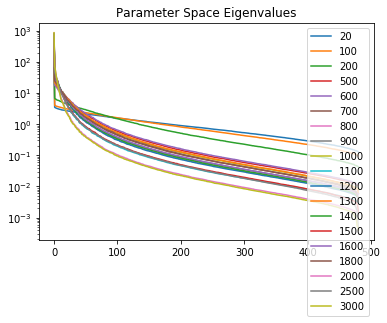

In [12]:
[plt.semilogy(all_eig_list[0][xx][0], label = str(n_list[xx])) for xx in range(len(n_list))]
plt.legend()
plt.title('Parameter Space Eigenvalues')

Text(0.5, 1.0, 'Function Space Eigenvalues')

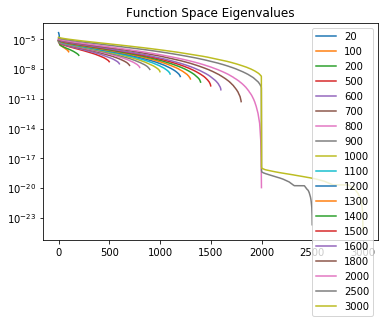

In [13]:
[plt.semilogy(all_eig_list[0][xx][1], label = str(n_list[xx])) for xx in range(len(n_list))]
plt.legend()
plt.title('Function Space Eigenvalues')

In [14]:
def eff_dim(x, s = 1.):
    return np.sum(x / (x + s))

In [16]:
eff_dims_parameters = [eff_dim(all_eig_list[0][x][0]) for x in range(len(n_list))]
eff_dims_fns = [eff_dim(all_eig_list[0][x][1], s=1e-4) for x in range(len(n_list))]


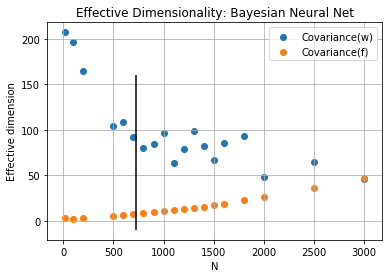

In [18]:
plt.scatter(n_list, eff_dims_parameters, label = 'Covariance(w)')
plt.scatter(n_list, eff_dims_fns, label = 'Covariance(f)')
plt.legend()
plt.ylabel('Effective dimension')
plt.xlabel('N')
plt.grid()
plt.title('Effective Dimensionality: Bayesian Neural Net')
plt.vlines(726, -10, 160)
#plt.ylim((0, 140))
#plt.scatter([20, 200, 2000], eff_dims_fns)

In [19]:
import pickle

In [20]:
with open('../../saved-experiments/bnn_regression_evals.pkl', 'wb') as handle:
    pickle.dump(all_eig_list, handle)